In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
import sys
sys.path.append('../')
from utils import invert, to_dense, sum
from datasets import NetflixData, NetflixGenreCastData, MovieLensData, MovieLensUserData
import pickle
import pandas as pd
import os
import missingno as msno
from itertools import chain

root = os.path.abspath("D:/OneDrive - Singapore Management University/datasets/")

# df_imdb

In [224]:
df_imdb = pd.read_table(os.path.join(root, "imdb", "title.basics.tsv", "data.tsv"), delimiter='\t', header=0)
display(df_imdb)

C:\Users\nieht\AppData\Local\Temp\ipykernel_29636\818886752.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imdb = pd.read_table(os.path.join(root, "imdb", "title.basics.tsv", "data.tsv"), delimiter='\t', header=0)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10080280,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10080281,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10080282,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10080283,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [150]:
# title.crew.tsv will put directors into writers

df_imdb_crew = pd.read_table(os.path.join(root, "imdb", "title.crew.tsv", "data.tsv"), delimiter='\t', header=0)
display(df_imdb_crew)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
10080280,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10080281,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
10080282,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10080283,tt9916856,nm10538645,nm6951431


In [225]:
df_imdb_cast = pd.read_table(os.path.join(root, "imdb", "title.principals.tsv", "data.tsv"), delimiter='\t', header=0)
display(df_imdb_cast['category'].unique()[1:])
display(df_imdb_cast)

array(['director', 'cinematographer', 'composer', 'producer', 'editor',
       'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
57680346,tt9916880,5,nm0584014,director,\N,\N
57680347,tt9916880,6,nm0996406,director,principal director,\N
57680348,tt9916880,7,nm1482639,writer,\N,\N
57680349,tt9916880,8,nm2586970,writer,books,\N


# df_25m_imdb

In [226]:
df_25m_imdb = pd.read_table(os.path.join(root, "ml-imdb", "ml-25m", "movie_ml_imdb.csv"), delimiter='\t', header=0)
# df_25m_imdb['imdb_id'] = df_25m_imdb['imdb_id'].apply(lambda x: x.split('/'))
display(df_25m_imdb)

,movieId,title,genres_ml,year,tconst,writer,actor,director,producer,actress,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_imdb,directors,writers
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,...,movie,Toy Story,Toy Story,0,1995,\N,81,Adventure|Animation|Comedy,nm0005124,nm0005124|nm0230032|nm0004056|nm0710020|nm0923...
1,2,Jumanji,Adventure|Children|Fantasy,1995,tt0113497,nm0378144|nm0852430|nm0833164|nm0885575,nm0000245|nm0404993,nm0002653,nm0472256,nm0000379|nm0001372,...,movie,Jumanji,Jumanji,0,1995,\N,104,Adventure|Comedy|Family,nm0002653,nm0378144|nm0852430|nm0833164|nm0885575
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,nm0425756,nm0000527|nm0000493,nm0222043,nm0075828|nm0204862,nm0000268|nm0000047,...,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,Comedy|Romance,nm0222043,nm0425756
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,tt0114885,nm0573334|nm0060103,\N,nm0001845,nm0771834|nm0842470,nm0001365|nm0000291|nm0222643|nm0005375,...,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,Comedy|Drama|Romance,nm0001845,nm0573334|nm0060103
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,nm0352443|nm0329304|nm0583600,nm0000188|nm0001737,nm0796124,\N,nm0000473|nm0931090,...,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,Comedy|Family|Romance,nm0796124,nm0352443|nm0329304|nm0583600|nm0796124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,We,Drama,2018,tt6671244,nm1818234,nm9400914|nm7904438,nm1415482,nm1761379,nm9547544|nm9560986,...,movie,Wij,Wij,0,2018,\N,100,Drama,nm1415482,nm1415482|nm1818234
62419,209159,Window of the Soul,Documentary,2001,tt0297986,\N,\N,nm1065588|nm0142504,nm0848542,\N,...,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,nm0142504|nm1065588,nm0142504|nm1065588
62420,209163,Bad Poems,Comedy|Drama,2018,tt6755366,\N,nm2520391|nm0468514,\N,nm2726042,nm6331240|nm0847744,...,movie,Bad Poems,Rossz versek,0,2018,\N,97,Comedy|Drama,nm2520391,nm2520391
62421,209169,A Girl Thing,(no genres listed),2001,tt0249603,\N,\N,nm0003022,nm0076184,nm0001009|nm0000330|nm0000360|nm0001201,...,tvMovie,A Girl Thing,A Girl Thing,0,2001,\N,237,Comedy|Drama|Romance,nm0003022,nm0003022


# df_100k

In [71]:
# 943 users, 1682 items, 100000 ratings

df_100k = pd.read_table(os.path.join(root, "ml-100k", "u.data"), delimiter='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
df_100k["timestamp"] = pd.to_datetime(df_100k["timestamp"], unit='s')
display(df_100k)

df_100k_genre = pd.read_table(os.path.join(root, "ml-100k", "u.genre"), delimiter='|', header=None, names=['genre', 'genreId'])
display(df_100k_genre)

df_100k_item = pd.read_table(os.path.join(root, "ml-100k", "u.item"), delimiter='|', header=None, encoding="latin1")
df_100k_item.drop(3, axis=1, inplace=True)
display(df_100k_item)

df_100k_occupation = pd.read_table(os.path.join(root, "ml-100k", "u.occupation"), delimiter='|', header=None, names=['occupation'])
display(df_100k_occupation)

,userId,movieId,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03
99997,276,1090,1,1997-09-20 22:49:55
99998,13,225,2,1997-12-17 22:52:36


,genre,genreId
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Fantasy,9


,0,1,2,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer
5,entertainment
6,executive
7,healthcare
8,homemaker
9,lawyer


In [287]:
df_100k_user = pd.read_table(os.path.join(root, "ml-100k", "u.user"), delimiter='|', header=None, names=['uid', 'age', 'gender', 'occupation', 'zip'])
# df_100k_item.drop(3, axis=1, inplace=True)
display(df_100k_user)

,uid,age,gender,occupation,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [288]:
# preprocessing
df_profiles = df_100k_user
df_occupations = df_100k_occupation
df_profiles['gender'] = df_profiles['gender'].apply(lambda x: 0 if x == 'F' else 1)
df_profiles['age'] = df_profiles['age'].apply(lambda x: int(x / 15))
df_profiles['occupation'] = df_profiles['occupation'].apply(lambda x: df_occupations[df_occupations['occupation'] == x].index[0] if isinstance(x, str) else x)

engine = SearchEngine()
df_profiles['zip'] = df_profiles['zip'].apply(lambda x: engine.by_zipcode(x).state if engine.by_zipcode(x) is not None else 'NA')

In [289]:
df_profiles.tail(50)

,uid,age,gender,occupation,zip
893,894,3,1,3,OK
894,895,2,0,10,FL
895,896,1,1,20,CA
896,897,2,1,13,FL
897,898,1,1,8,IL
898,899,2,1,13,MN
899,900,4,1,15,PA
900,901,2,1,6,NA
901,902,3,0,1,OR
902,903,1,1,3,MD


In [291]:
attributes = ['age', 'gender', 'occupation', 'zip']
for attr in attributes:
    attr_list = sorted(df_profiles[attr].unique())
    print(attr_list)

[0, 1, 2, 3, 4]
[0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
['AE', 'AK', 'AL', 'AP', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NA', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [306]:
type(df_profiles['zip'] == 'NA')

pandas.core.series.Series

In [322]:
from scipy.sparse import csr_matrix, hstack
a = csr_matrix((4, 2))
b.toarray()

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [323]:
b.toarray()

array([[0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.]])

In [324]:
hstack((a, b))

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [319]:
a.toarray()

array([[0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.]])

# matching ml-100k with imdb

In [49]:
df_100k_imdb = pd.read_table(os.path.join(root, "ml-imdb", "ml-100k", "matched_title.pd"), delimiter='\t', header=0)
df_100k_imdb['imdb_id'] = df_100k_imdb['imdb_id'].apply(lambda x: x.split('/'))
display(df_100k_imdb)

,ml_id,imdb_id
0,1,"[tt0114709, tt0178952]"
1,2,"[tt0113189, tt5084398, tt21638798]"
2,3,[tt0113101]
3,4,[tt0113161]
4,5,[tt0112722]
...,...,...
1672,1678,[tt0119711]
1673,1679,[tt0120594]
1674,1680,[tt0120148]
1675,1681,[tt0111804]


In [185]:
missing = [x for x in range(1, 1683) if x not in df_100k_imdb['ml_id'].values]
display(missing, df_100k_item[df_100k_item[0].isin(missing)])

[114, 267, 1358, 1359, 1420]

,0,1,2,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,ml_id,imdb_id
113,114,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,http://us.imdb.com/Title?Wallace+%26+Gromit%3A...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,None,None
266,267,unknown,None,None,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,None
1357,1358,The Deadly Cure (1996),16-Sep-1996,None,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,None,None
1358,1359,Boys in Venice (1996),24-Sep-1996,None,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,None,None
1419,1420,Gilligan's Island: The Movie (1998),01-Jan-1997,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,None,None


In [166]:
df_100k_item = df_100k_item.merge(df_100k_imdb, left_on=0, right_on='ml_id', how='left')

In [177]:
df_100k_item = df_100k_item.replace({np.nan: None})

In [188]:
# df_100k_item = df_100k_item.drop(index=266)
# df_100k_item.reset_index(drop=True, inplace=True)
df_100k_item

,0,1,2,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,ml_id,imdb_id
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1.0,tt0114709
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,2.0,tt0113189
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.0,tt0113101
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,4.0,tt0113161
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,5.0,tt0112722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1678.0,tt0119711
1677,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1679.0,tt0120594
1678,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1680.0,tt0120148
1679,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1681.0,tt0111804


In [178]:
for i in range(len(df_100k_item)):
    if df_100k_item['imdb_id'][i] == None:
        print(i)

113
266
1357
1358
1419


In [193]:
crew = ['director', 'writer', 'actor', 'actress', 'cinematographer', 'composer', 'producer', 'editor', 'production_designer', 'archive_footage', 'archive_sound']

columns = ['ml_id', 'imdb_id', 
'ml_title', 'imdb_title', 
'ml_year', 'imdb_year', 
'ml_genres', 'imdb_genres'] + crew

df_ml_100k_imdb = pd.DataFrame(columns=columns)

In [218]:
df_ml_100k_imdb = pd.DataFrame(columns=columns)

for i in tqdm(range(len(df_100k_item))): # 1682
    row_dict = {}
    for c in columns:
        row_dict[c] = []

    # ml * 4
    for idx, c in enumerate(['ml_id', 'ml_title', 'ml_year']):
        row_dict[c] = df_100k_item[idx][i]
    row_dict['ml_year'] = int(row_dict['ml_year'].split('-')[-1])
    row_dict['ml_genres'] = [df_100k_genre['genre'][x-5] for x in range(6, 24)] # drop unknown

    # imdb * 4
    row_dict['imdb_id'] = df_100k_item['imdb_id'][i]
    imdb_id = row_dict['imdb_id']

    if row_dict['imdb_id'] == None:
        # imdb * 3 + 11
        for c in ['imdb_title', 'imdb_year', 'imdb_genres'] + crew:
            row_dict[c] = None
    else:
        idx_25m = df_25m_imdb['tconst'].eq(imdb_id)
        
        if idx_25m.any(): # found in df_25m_imdb
            # imdb * 3
            row_dict['imdb_title'] = df_25m_imdb['primaryTitle'].values[idx_25m][0]
            row_dict['imdb_year'] = int(df_25m_imdb['startYear'].values[idx_25m][0])
            row_dict['imdb_genres'] = df_25m_imdb['genres_imdb'].values[idx_25m][0].split('|')
            # 11
            for c in crew:
                row_dict[c] = df_25m_imdb[c].values[idx_25m][0].split('|')
                if row_dict[c][0] == '\\N':
                    row_dict[c] = None
            

        else: # to find in df_imdb
            idx_imdb = df_imdb['tconst'].eq(imdb_id)
            # imdb * 3

            row_dict['imdb_title'] = df_imdb['primaryTitle'].values[idx_imdb][0]
            row_dict['imdb_year'] = int(df_imdb['startYear'].values[idx_imdb][0])
            row_dict['imdb_genres'] = df_imdb['genres'].values[idx_imdb][0].split(',')

            idx_cast = df_imdb_cast['tconst'].eq(imdb_id)
            df_cast = df_imdb_cast.loc[idx_cast]
            for c in crew:
                idx_sub = df_cast['category'].eq(c)
                if idx_sub.any():
                    df_cast_sub = df_cast.loc[idx_sub]
                    row_dict[c] = df_cast_sub['nconst'].to_list()
                else:
                    row_dict[c] = None

    row = [row_dict[key] for key in columns]
    
    df_ml_100k_imdb.loc[len(df_ml_100k_imdb.index)] = row

100%|██████████| 1681/1681 [01:08<00:00, 24.66it/s]


In [59]:
# file = open('ml_100k_imdb.pickle', 'wb')

# # dump information to that file
# pickle.dump(df_ml_100k_imdb, file)

df_ml_100k_imdb = pd.read_pickle("ml_100k_imdb.pickle")
df_ml_100k_imdb

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,imdb_genres,director,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story (1995),Toy Story,1995,1995,"[Action, Adventure, Animation, Children's, Com...","[Adventure, Animation, Comedy]",[nm0005124],"[nm0169505, nm0230032, nm0004056, nm0710020, n...","[nm0000158, nm0000741, nm0725543, nm0001815]",None,None,None,None,None,None,None,None
1,2,tt0113189,GoldenEye (1995),GoldenEye,1995,1995,"[Action, Adventure, Animation, Children's, Com...","[Action, Adventure, Thriller]",[nm0132709],"[nm0001220, nm0289833, nm0128997, nm0270761]","[nm0000112, nm0000293]","[nm0001713, nm0000463]",None,None,[nm0110483],None,None,None,None
2,3,tt0113101,Four Rooms (1995),Four Rooms,1995,1995,"[Action, Adventure, Animation, Children's, Com...",[Comedy],"[nm0025978, nm0734319, nm0001675, nm0000233, n...",None,"[nm0000619, nm0000104]","[nm0205423, nm0004866]",None,None,[nm0004744],None,None,None,None
3,4,tt0113161,Get Shorty (1995),Get Shorty,1995,1995,"[Action, Adventure, Animation, Children's, Com...","[Comedy, Crime, Thriller]",[nm0001756],"[nm0001465, nm0291082]","[nm0000432, nm0000362, nm0000237]",[nm0000623],None,[nm0527099],"[nm0787834, nm0792049]",None,None,None,None
4,5,tt0112722,Copycat (1995),Copycat,1995,1995,"[Action, Adventure, Animation, Children's, Com...","[Drama, Mystery, Thriller]",[nm0000750],"[nm0081189, nm0535189]","[nm0000551, nm0001530]","[nm0000244, nm0000456]",None,[nm0002366],"[nm0586969, nm0850516]",None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,1678,tt0119711,Mat' i syn (1997),Mother and Son,1998,1997,"[Action, Adventure, Animation, Children's, Com...",[Drama],[nm0812546],[nm0032685],[nm0025651],[nm0315407],[nm0299513],[nm0412155],[nm0473983],[nm0783978],"[nm0954559, nm0728820]",None,None
1677,1679,tt0120594,B. Monkey (1998),B. Monkey,1998,1998,"[Action, Adventure, Animation, Children's, Com...","[Crime, Drama, Romance]",[nm0705535],"[nm0203577, nm0454573, nm0859241]","[nm0364813, nm0000391, nm0001667]",[nm0000782],None,None,"[nm0941262, nm0883267]",None,None,None,None
1678,1680,tt0120148,Sliding Doors (1998),Sliding Doors,1998,1998,"[Action, Adventure, Animation, Children's, Com...","[Comedy, Drama, Fantasy]",[nm0398185],None,"[nm0001314, nm0001487]","[nm0000569, nm0000675]",[nm0001899],[nm0386595],"[nm0104088, nm0394564, nm0001628]",None,None,None,None
1679,1681,tt0111804,You So Crazy (1994),Martin Lawrence: You So Crazy,1994,1994,"[Action, Adventure, Animation, Children's, Com...","[Comedy, Documentary]",[nm0772095],None,None,None,[nm0016473],None,"[nm0399144, nm0005604, nm0555684]","[nm0623628, nm0002377]",[nm0393922],None,None


In [63]:
df_ml_100k_imdb['ml_genres']

0       [Action, Adventure, Animation, Children's, Com...
1       [Action, Adventure, Animation, Children's, Com...
2       [Action, Adventure, Animation, Children's, Com...
3       [Action, Adventure, Animation, Children's, Com...
4       [Action, Adventure, Animation, Children's, Com...
                              ...                        
1676    [Action, Adventure, Animation, Children's, Com...
1677    [Action, Adventure, Animation, Children's, Com...
1678    [Action, Adventure, Animation, Children's, Com...
1679    [Action, Adventure, Animation, Children's, Com...
1680    [Action, Adventure, Animation, Children's, Com...
Name: ml_genres, Length: 1681, dtype: object

In [64]:
df_ml_100k_imdb.loc[len(df_ml_100k_imdb)] = [267, None, 'unknown'] + [None] * (len(df_ml_100k_imdb.columns) - 3)

In [84]:
from tqdm import tqdm

In [85]:
for i in tqdm(df_ml_100k_imdb.index):
    ml_id = df_ml_100k_imdb['ml_id'].values[i]
    df_ml_100k_imdb['ml_genres'][i] = [df_100k_genre['genre'][x-5] for x in range(6, 24) if df_100k_item[x][ml_id - 1] == 1]

  0%|          | 0/1682 [00:00<?, ?it/s]C:\Users\nieht\AppData\Local\Temp\ipykernel_3432\791161073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml_100k_imdb['ml_genres'][i] = [df_100k_genre['genre'][x-5] for x in range(6, 24) if df_100k_item[x][ml_id - 1] == 1]
100%|██████████| 1682/1682 [00:00<00:00, 2821.40it/s]


In [81]:
i = 266
ml_id = i + 1
[df_100k_genre['genre'][x-5] for x in range(6, 24) if df_100k_item[x][ml_id - 1] == 1]

[]

In [87]:
df_ml_100k_imdb.to_pickle("ml_100k_imdb.pickle")

In [69]:
df_ml_100k_imdb = df_ml_100k_imdb.reset_index(drop=True)

In [88]:
df_ml_100k_imdb

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,imdb_genres,director,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story (1995),Toy Story,1995,1995,"[Animation, Children's, Comedy]","[Adventure, Animation, Comedy]",[nm0005124],"[nm0169505, nm0230032, nm0004056, nm0710020, n...","[nm0000158, nm0000741, nm0725543, nm0001815]",None,None,None,None,None,None,None,None
1,2,tt0113189,GoldenEye (1995),GoldenEye,1995,1995,"[Action, Adventure, Thriller]","[Action, Adventure, Thriller]",[nm0132709],"[nm0001220, nm0289833, nm0128997, nm0270761]","[nm0000112, nm0000293]","[nm0001713, nm0000463]",None,None,[nm0110483],None,None,None,None
2,3,tt0113101,Four Rooms (1995),Four Rooms,1995,1995,[Thriller],[Comedy],"[nm0025978, nm0734319, nm0001675, nm0000233, n...",None,"[nm0000619, nm0000104]","[nm0205423, nm0004866]",None,None,[nm0004744],None,None,None,None
3,4,tt0113161,Get Shorty (1995),Get Shorty,1995,1995,"[Action, Comedy, Drama]","[Comedy, Crime, Thriller]",[nm0001756],"[nm0001465, nm0291082]","[nm0000432, nm0000362, nm0000237]",[nm0000623],None,[nm0527099],"[nm0787834, nm0792049]",None,None,None,None
4,5,tt0112722,Copycat (1995),Copycat,1995,1995,"[Crime, Drama, Thriller]","[Drama, Mystery, Thriller]",[nm0000750],"[nm0081189, nm0535189]","[nm0000551, nm0001530]","[nm0000244, nm0000456]",None,[nm0002366],"[nm0586969, nm0850516]",None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,tt0119711,Mat' i syn (1997),Mother and Son,1998,1997,[Drama],[Drama],[nm0812546],[nm0032685],[nm0025651],[nm0315407],[nm0299513],[nm0412155],[nm0473983],[nm0783978],"[nm0954559, nm0728820]",None,None
1678,1679,tt0120594,B. Monkey (1998),B. Monkey,1998,1998,"[Romance, Thriller]","[Crime, Drama, Romance]",[nm0705535],"[nm0203577, nm0454573, nm0859241]","[nm0364813, nm0000391, nm0001667]",[nm0000782],None,None,"[nm0941262, nm0883267]",None,None,None,None
1679,1680,tt0120148,Sliding Doors (1998),Sliding Doors,1998,1998,"[Drama, Romance]","[Comedy, Drama, Fantasy]",[nm0398185],None,"[nm0001314, nm0001487]","[nm0000569, nm0000675]",[nm0001899],[nm0386595],"[nm0104088, nm0394564, nm0001628]",None,None,None,None
1680,1681,tt0111804,You So Crazy (1994),Martin Lawrence: You So Crazy,1994,1994,[Comedy],"[Comedy, Documentary]",[nm0772095],None,None,None,[nm0016473],None,"[nm0399144, nm0005604, nm0555684]","[nm0623628, nm0002377]",[nm0393922],None,None


<AxesSubplot:>

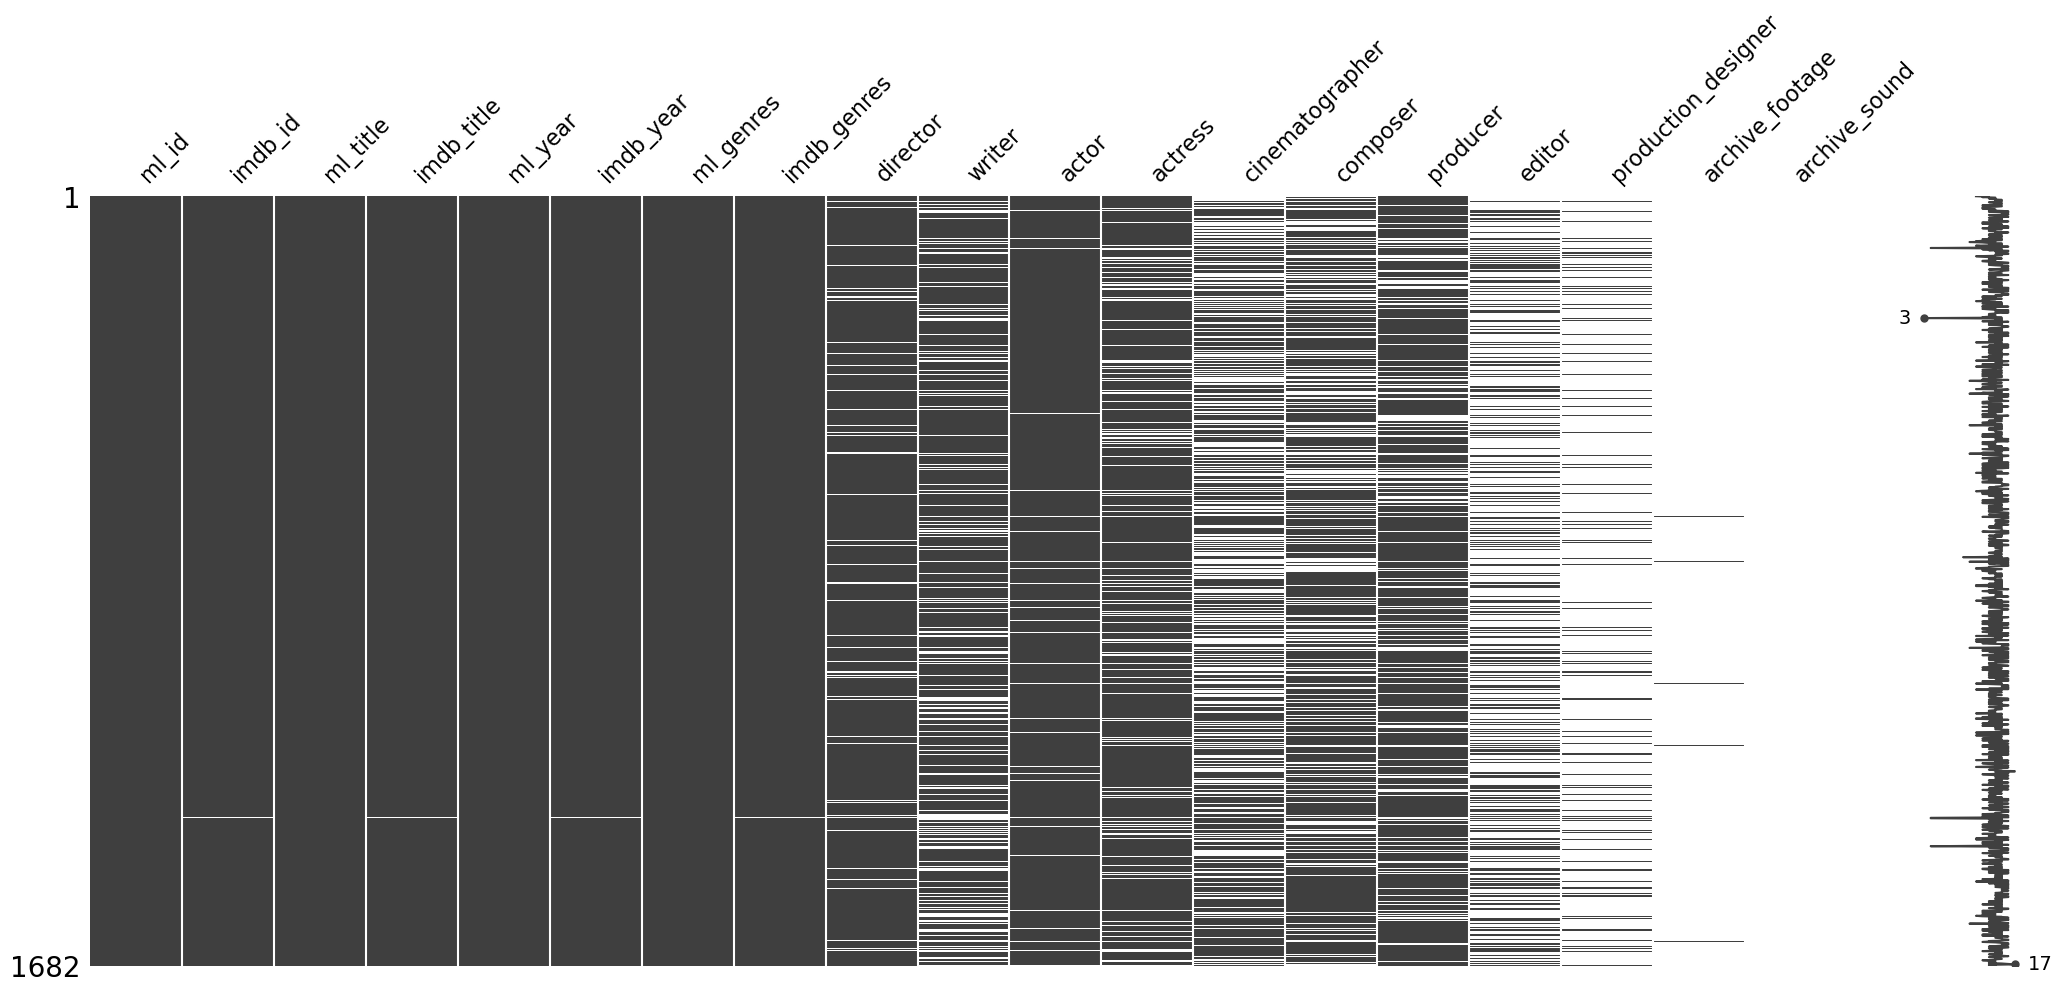

In [89]:
msno.matrix(df_ml_100k_imdb)

<AxesSubplot:>

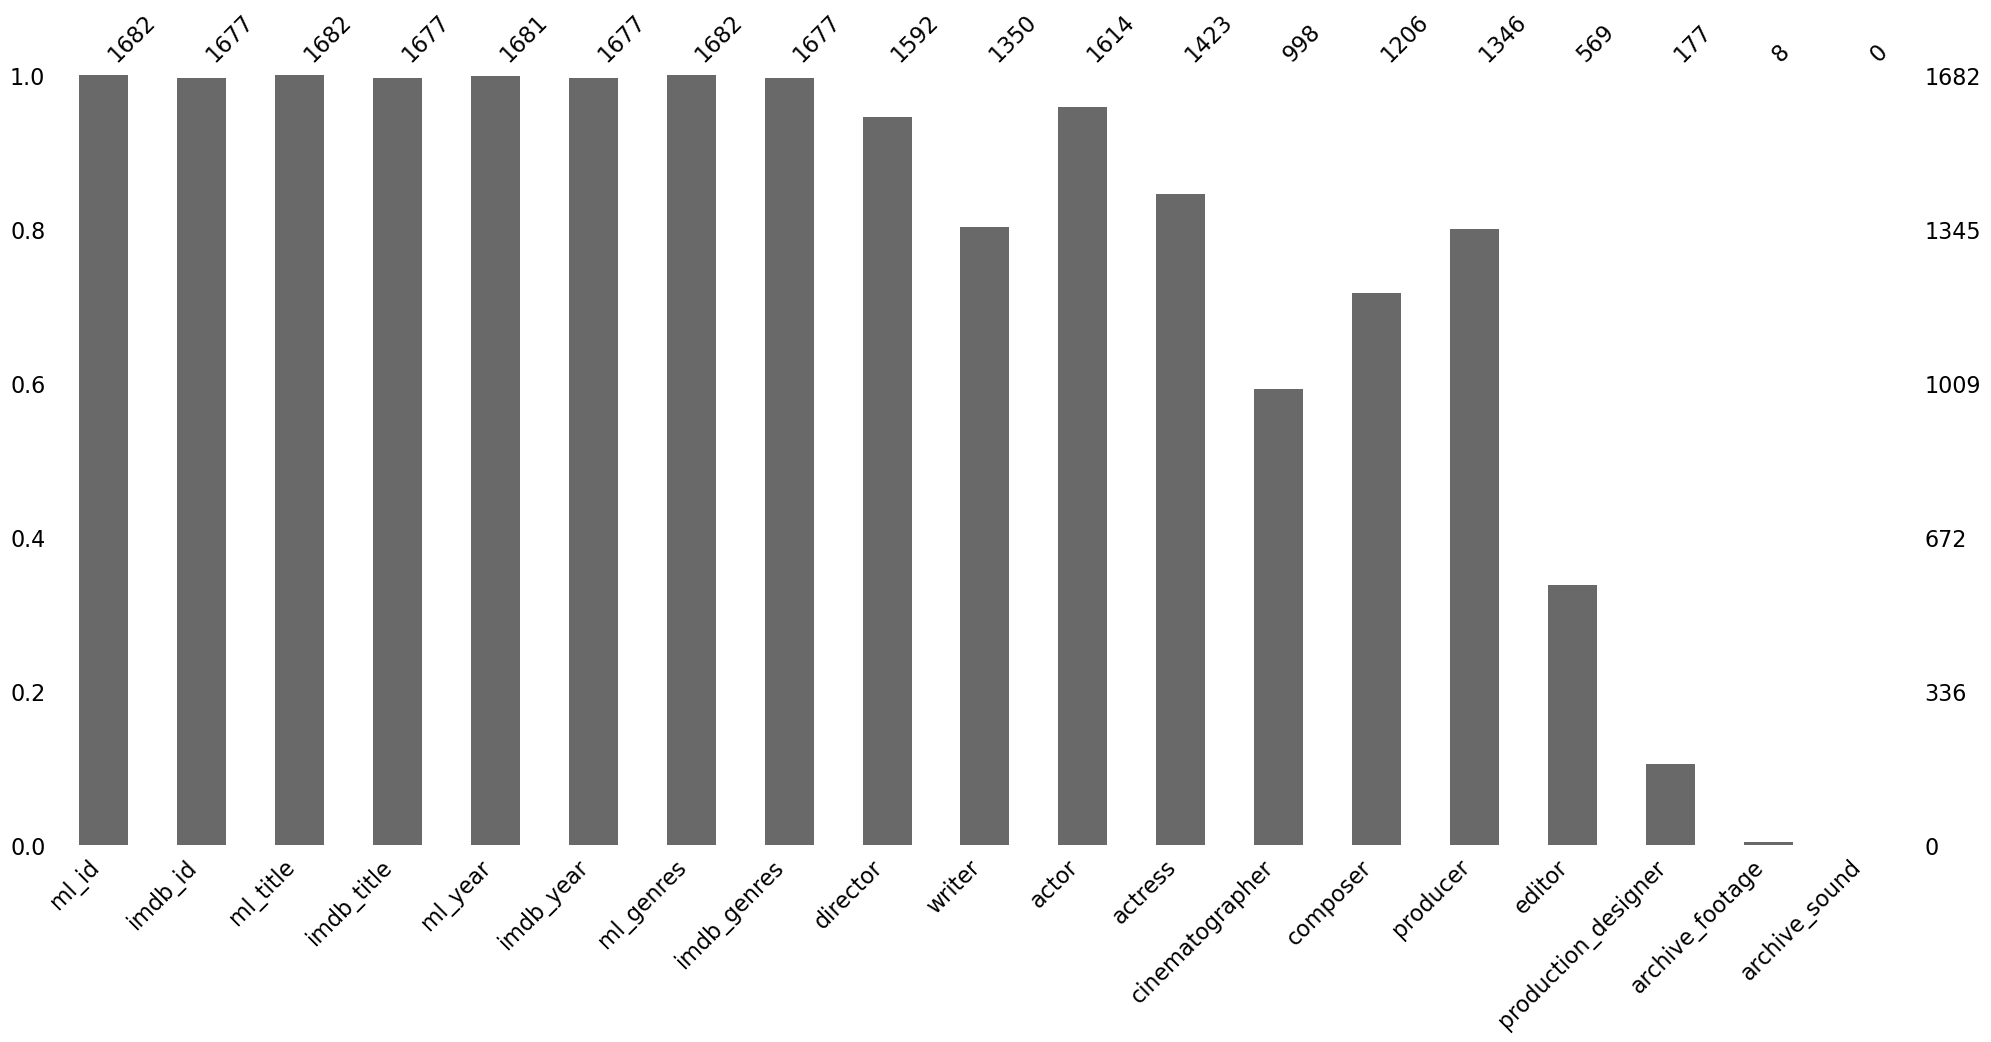

In [90]:
msno.bar(df_ml_100k_imdb)

## fix missing

In [131]:
df_100k_imdb = df_100k_imdb.reset_index(drop=True)

In [72]:
from tqdm import tqdm
# tqdm.pandas()
# result = df_100k_imdb['imdb_id'].head(5).progress_apply(lambda x: [((df_imdb['tconst'].eq(iid)).any(), iid) for iid in x])

df = df_100k_imdb['imdb_id']#.head(5)

ml_ids = []
result = []

for imdb_ids in tqdm(df):
    r = []
    if len(imdb_ids) == 1:
        continue
    for iid in imdb_ids:
        idx = df_imdb['tconst'].eq(iid)

        if not idx.any():
            continue
        else:
            item_type = df_imdb['titleType'].values[idx][0]
        
        if item_type == 'movie' or item_type == 'short':
            r.append(iid)
        # r.append((df_imdb['titleType'].values[idx][0], df_imdb['genres'].values[idx][0]))
    result.append(r)

# result = df_100k_imdb['imdb_id'].apply(lambda x: [(df_imdb['tconst'].eq(iid)).any() for iid in x])

100%|██████████| 1677/1677 [04:42<00:00,  5.93it/s]


In [105]:
# df_100k_imdb = df_100k_imdb.drop(index=1354)

In [110]:
df_100k_imdb

,ml_id,imdb_id
0,1,[tt0114709]
1,2,[tt0113189]
2,3,[tt0113101]
3,4,[tt0113161]
4,5,[tt0112722]
...,...,...
1672,1678,[tt0119711]
1673,1679,[tt0120594]
1674,1680,[tt0120148]
1675,1681,[tt0111804]


In [114]:
# df_100k_imdb['imdb_id'] = df_100k_imdb['imdb_id'].apply(lambda x: x[0])

In [98]:
for i in df_100k_imdb.index:
    if len(df_100k_imdb['imdb_id'][i]) < 1:
        print(">1", i, df_100k_imdb['ml_id'][i])

>1 1354 1359


In [95]:
a = 0
for i in df_100k_imdb.index:
    if len(df_100k_imdb['imdb_id'][i]) > 1:
        df_100k_imdb['imdb_id'][i] = result[a]
        # if len(result[a]) == 1:
        #     pass
        # else:
        #     ml_id = df_100k_imdb['ml_id'][i]
        #     ml_tt = df_100k_item[1][ml_id - 1]
        #     ml_gr = [df_100k_genre['genre'][x-5] for x in range(5, 24) if df_100k_item[x][ml_id - 1] == 1]
        #     print(ml_id, ml_tt, ml_gr)
        #     for r in result[a]:
        #         idx = df_imdb['tconst'].eq(r)
        #         id = df_imdb['tconst'].values[idx][0]
        #         pt = df_imdb['primaryTitle'].values[idx][0]
        #         sy = df_imdb['startYear'].values[idx][0]
        #         tt = df_imdb['titleType'].values[idx][0]
        #         gr = df_imdb['genres'].values[idx][0]
        #         print('\t', a, id, pt, sy, tt, gr)
        #     choice = input('What is your choice?\n')
        #     if choice[:2] == 'tt':
        #         result[a] = [choice]
        #     elif choice == 'None':
        #         result[a] = []
        #     else:
        #         result[a] = [result[a][int(choice)]]
        a += 1    

C:\Users\nieht\AppData\Local\Temp\ipykernel_29636\1909127144.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_100k_imdb['imdb_id'][i] = result[a]


In [134]:
# open a file, where you ant to store the data
file = open('ml_100k_matching_result.pickle', 'wb')

# dump information to that file
pickle.dump(df_100k_imdb, file)

In [135]:
df_100k_imdb

,ml_id,imdb_id
0,1,tt0114709
1,2,tt0113189
2,3,tt0113101
3,4,tt0113161
4,5,tt0112722
...,...,...
1672,1678,tt0119711
1673,1679,tt0120594
1674,1680,tt0120148
1675,1681,tt0111804


In [144]:
not_in_ml25m_imdb = []

for id in tqdm(df_100k_imdb['imdb_id']):
    if df_25m_imdb['tconst'].eq(id).any():
        pass
    else:
        not_in_ml25m_imdb.append(id)

print(len(not_in_ml25m_imdb))

not_in_full_imdb = []

for id in tqdm(not_in_ml25m_imdb):
    if df_imdb['tconst'].eq(id).any():
        pass
    else:
        not_in_full_imdb.append(id)

print(len(not_in_full_imdb))



100%|██████████| 1677/1677 [00:05<00:00, 311.27it/s]


In [149]:
not_in_full_imdb

[]

# df_1m

In [44]:
names = ['user_id', 'gender', 'age', 'occupation', 'zip']
df_1m_user = pd.read_table(os.path.join(root, "ml-1m", 'users.dat'), sep='::', header=None, names=names, engine='python')
display(df_1m_user)

names = ['user_id', 'movie_id', 'rating', 'timestamp']
df_1m = pd.read_table(os.path.join(root, "ml-1m", "ratings.dat"), sep='::', header=None, names=names, engine='python')
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"], unit='s')
display(df_1m)

df_1m_item = pd.read_table(os.path.join(root, "ml-1m", "movies.dat"), sep='::', header=None, encoding='latin1', engine='python')
display(df_1m_item)

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


,user_id,movie_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [47]:
df_1m_item.loc[250:270]

,0,1,2
250,253,Interview with the Vampire (1994),Drama|Horror
251,254,Jefferson in Paris (1995),Drama
252,255,"Jerky Boys, The (1994)",Comedy
253,256,Junior (1994),Comedy|Sci-Fi
254,257,Just Cause (1995),Mystery|Thriller
255,258,"Kid in King Arthur's Court, A (1995)",Adventure|Children's|Comedy|Fantasy|Romance
256,259,Kiss of Death (1995),Crime|Drama|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
258,261,Little Women (1994),Drama
259,262,"Little Princess, A (1995)",Children's|Drama


In [46]:
df_100k_item.loc[250:270]

,0,1,2,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
250,251,Shall We Dance? (1996),11-Jul-1997,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
251,252,"Lost World: Jurassic Park, The (1997)",23-May-1997,http://us.imdb.com/M/title-exact?Lost%20World%...,0,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
252,253,"Pillow Book, The (1995)",13-Jun-1997,http://us.imdb.com/M/title-exact?Pillow%20Book...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
253,254,Batman & Robin (1997),20-Jun-1997,http://us.imdb.com/M/title-exact?Batman+%26+Ro...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,255,My Best Friend's Wedding (1997),20-Jun-1997,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
255,256,When the Cats Away (Chacun cherche son chat) (...,20-Jun-1997,http://us.imdb.com/M/title-exact?Chacun+cherch...,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
256,257,Men in Black (1997),04-Jul-1997,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
257,258,Contact (1997),11-Jul-1997,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
258,259,George of the Jungle (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?George+of+the...,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
259,260,Event Horizon (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?Event+Horizon...,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


# matching ml-1m with imdb

In [9]:
df_1m_imdb = pd.read_table(os.path.join(root, "ml-imdb", "ml-1m", "matched_title.pd"), delimiter='\t', header=0)
df_1m_imdb['imdb_id'] = df_1m_imdb['imdb_id'].apply(lambda x: x.split('/'))
display(df_1m_imdb)

,ml_id,imdb_id
0,1,"[tt0114709, tt0178952]"
1,2,[tt0113497]
2,3,[tt0113228]
3,4,[tt0114885]
4,5,[tt0113041]
...,...,...
3873,3948,[tt0212338]
3874,3949,[tt0180093]
3875,3950,[tt0170691]
3876,3951,[tt0202641]


In [101]:
missing = [x for x in df_1m_item['movieId'].values if x not in df_1m_imdb['ml_id'].values]
display(missing, df_1m_item[df_1m_item['movieId'].isin(missing)])
display(df_1m_item[df_1m_item['movieId'].isin(missing)]['title'].values)

[720, 1164, 2053, 2258, 3376]

,movieId,title,genres
711,720,Wallace & Gromit: The Best of Aardman Animatio...,Animation
1148,1164,Two or Three Things I Know About Her (1966),Drama
1984,2053,"Honey, I Blew Up the Kid (1992)",Children's|Comedy|Sci-Fi
2189,2258,Master Ninja I (1984),Action
3307,3376,"Fantastic Night, The (La Nuit Fantastique) (1949)",Romance


array(['Wallace & Gromit: The Best of Aardman Animation (1996)',
       'Two or Three Things I Know About Her (1966)',
       'Honey, I Blew Up the Kid (1992)', 'Master Ninja I (1984)',
       'Fantastic Night, The (La Nuit Fantastique) (1949)'], dtype=object)

In [106]:
iid = [None, 'tt0060304', 'tt0104437', 'tt0086756', 'tt0041705']

In [107]:
a = 0
for i in df_1m_item[df_1m_item['movieId'].isin(missing)]['title'].index:
    df_1m_imdb.loc[len(df_1m_imdb)] = [i, iid[a]]
    a+=1

In [117]:
df_1m_imdb

,ml_id,imdb_id
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
...,...,...
3878,3948,tt0212338
3879,3949,tt0180093
3880,3950,tt0170691
3881,3951,tt0202641


In [23]:
multi_match = [df_1m_imdb['ml_id'][x] for x in df_1m_imdb.index if len(df_1m_imdb['imdb_id'][x]) > 1]
display(len(multi_match), df_1m_imdb[df_1m_imdb['ml_id'].isin(multi_match)])

480

,ml_id,imdb_id
0,1,"[tt0114709, tt0178952]"
5,6,"[tt0113277, tt0525336]"
9,10,"[tt0113189, tt5084398, tt21638798]"
14,15,"[tt0112760, tt6227580]"
16,17,"[tt1265789, tt0114388]"
...,...,...
3820,3895,"[tt0204626, tt0296275]"
3829,3904,"[tt0188694, tt0504960, tt3990990]"
3837,3912,"[tt0210567, tt0217912]"
3862,3937,"[tt0088024, tt6525802]"


In [18]:
type_list = []
imdb_list = []
title_list = []
genre_list = []

def find_best_match(ml_id, imdb_ids):
    type_list = []
    imdb_list = []
    title_list = []
    genre_list = []

    idx = df_1m_item['movieId'].eq(ml_id)
    ml_genres = df_1m_item['genres'].values[idx][0]
    ml_title = df_1m_item['title'].values[idx][0]

    imdb_id = imdb_ids[0]

    if not imdb_id[:2] == 'tt':
        print(f"[I] No matching IMDB id for {ml_id}")
        # return None

    # if len(imdb_ids) == 1:
    #     return imdb_ids
        
    # for iid in imdb_ids:
    #     idx = df_imdb['tconst'].eq(iid)

    #     if not idx.any():
    #         print(f"[W] No matching IMDB id for {ml_id}")
    #         return None
        
    #     type_list.append(df_imdb['titleType'].values[idx][0])
    #     imdb_list.append(df_imdb['tconst'].values[idx][0])
    #     title_list.append(df_imdb['primaryTitle'].values[idx][0])
    #     genre_list.append(df_imdb['genres'].values[idx][0])

    # type_list = np.array(type_list)
    # imdb_list = np.array(imdb_list)
    # title_list = np.array(title_list)
    # genre_list = np.array(genre_list)

    # movie_count = []
    # for i, t in enumerate(type_list):
    #     if t == 'movie':
    #         movie_count.append(i)
    # if len(movie_count) == 1:
    #     imdb_id = imdb_list[movie_count[0]]
    #     return [imdb_id]

    # human feedback
        print(ml_id, ml_title, ml_genres)
        # for i in range(len(type_list)):
        #     print('    ', i, type_list[i], imdb_list[i], title_list[i], genre_list[i])

        # choice = input('What is your choice?\n')
        # if choice[:2] == 'tt':
        #     imdb_ids = [choice]
        # elif choice == 'None':
        #     imdb_ids = None
        # else:
        #     imdb_ids = [imdb_list[int(choice)]]
    # return imdb_ids



In [7]:
from tqdm import tqdm

In [97]:
df_1m_imdb

,ml_id,imdb_id
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
...,...,...
3873,3948,tt0212338
3874,3949,tt0180093
3875,3950,tt0170691
3876,3951,tt0202641


In [119]:
df_1m_item

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [20]:
for i in tqdm(df_1m_imdb.index):
    ml_id, imdb_ids = df_1m_imdb['ml_id'][i], df_1m_imdb['imdb_id'][i]
    # df_1m_imdb['imdb_id'][i] = find_best_match(ml_id, imdb_ids)
    r = find_best_match(ml_id, imdb_ids)

100%|██████████| 3878/3878 [00:00<00:00, 14764.95it/s]


In [157]:
# df_1m_imdb = pd.read_pickle('ml_1m_matching_result.pickle')

# # open a file, where you ant to store the data
file = open('ml_1m_matching_result.pickle', 'wb')

# # dump information to that file
pickle.dump(df_ml_1m_matching_result, file)

In [56]:
df_1m_imdb['imdb_id'] = df_1m_imdb['imdb_id'].apply(lambda x: x[0] if x is not None else None)

In [86]:
df_1m_imdb

,ml_id,imdb_id
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
...,...,...
3873,3948,tt0212338
3874,3949,tt0180093
3875,3950,tt0170691
3876,3951,tt0202641


In [104]:
r = df_1m_imdb['imdb_id'].apply(lambda x: not isinstance(x, str))
r.values.sum()

2

In [85]:
r = df_1m_imdb['imdb_id'].apply(lambda x: x is None)
r.values.sum()

11

In [186]:
df_ml_1m_imdb = df_ml_1m_imdb.rename(columns=columns)
df_ml_1m_imdb.to_pickle("ml_1m_imdb.pickle")

In [187]:
df_ml_1m_imdb

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story,Toy Story,1995,1995,Animation|Children's|Comedy,Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Comedy,movie,...,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,\N,\N,\N,\N,\N,\N,\N,\N
1,2,tt0113497,Jumanji,Jumanji,1995,1995,Adventure|Children's|Fantasy,Adventure|Children|Fantasy,Adventure|Comedy|Family,movie,...,nm0378144|nm0852430|nm0833164|nm0885575,nm0000245|nm0404993,nm0000379|nm0001372,\N,\N,nm0472256,\N,\N,\N,\N
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,1995,Comedy|Romance,Comedy|Romance,Comedy|Romance,movie,...,nm0425756,nm0000527|nm0000493,nm0000268|nm0000047,nm0005714,nm0006293,nm0075828|nm0204862,\N,\N,\N,\N
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,1995,Comedy|Drama,Comedy|Drama|Romance,Comedy|Drama|Romance,movie,...,nm0573334|nm0060103,\N,nm0001365|nm0000291|nm0222643|nm0005375,\N,nm0004892,nm0771834|nm0842470,\N,\N,\N,\N
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,1995,Comedy,Comedy,Comedy|Family|Romance,movie,...,nm0352443|nm0329304|nm0583600,nm0000188|nm0001737,nm0000473|nm0931090,nm0204567,nm0006293,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,tt0212338,Meet the Parents,Meet the Parents,2000,2000,Comedy,Comedy,Comedy|Romance,movie,...,nm0322839|nm0164898|nm0381272|nm0357453,nm0001774|nm0000134,nm0001632|nm0001100,\N,\N,nm0742772,\N,\N,\N,\N
3879,3949,tt0180093,Requiem for a Dream,Requiem for a Dream,2000,2000,Drama,Drama,Drama,movie,...,nm0782968,nm0001467|nm0005541,nm0000995|nm0000124,nm0508732,nm0543739,nm0914615|nm0922279,\N,\N,\N,\N
3880,3950,tt0170691,Tigerland,Tigerland,2000,2000,Drama,Drama,Drama|War,movie,...,nm0458462|nm0570077,nm0268199|nm0205127|nm0004286|nm0347509,\N,\N,\N,nm0586969|nm0004927|nm0353187,\N,\N,\N,\N
3881,3951,tt0202641,Two Family House,Two Family House,2000,2000,Drama,Drama,Comedy|Drama|Romance,movie,...,\N,nm0728346|nm0176723,nm0531808|nm0621393,nm0562574,nm0006059,nm0365478|nm0459754,nm0502601,\N,\N,\N


In [88]:
df

,ml_id,imdb_id
693,702,None
1110,1127,None
1836,1907,None
1854,1925,None
2030,2102,None
2543,2616,None
2555,2628,None
2617,2690,None
2917,2990,None
2935,3008,None


In [95]:
df_1m_imdb

,ml_id,imdb_id
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
...,...,...
3873,3948,tt0212338
3874,3949,tt0180093
3875,3950,tt0170691
3876,3951,tt0202641


In [90]:
df.merge(df_1m_item, left_on='ml_id', right_on='movieId', how='left')

,ml_id,imdb_id,movieId,title,genres
0,702,None,702,Faces (1968),Drama
1,1127,None,1127,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller
2,1907,None,1907,Mulan (1998),Animation|Children's
3,1925,None,1925,Wings (1927),Drama|Romance|War
4,2102,None,2102,Steamboat Willie (1940),Animation|Children's|Comedy|Musical
5,2616,None,2616,Dick Tracy (1990),Action|Crime
6,2628,None,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi
7,2690,None,2690,"Ideal Husband, An (1999)",Comedy
8,2990,None,2990,Licence to Kill (1989),Action
9,3008,None,3008,Last Night (1998),Thriller


In [102]:
iid = ['tt0062952', 'tt0096754', 'tt0120762', 'tt0018578', 'tt0019422', 'tt0099422', 'tt0120915', 'tt0122541', 'tt0097742', None, None]

In [103]:
a = 0
for i in df.index:
    df_1m_imdb['imdb_id'][i] = iid[a]
    a+=1

C:\Users\hongtuonie\AppData\Local\Temp\ipykernel_34264\3974687735.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1m_imdb['imdb_id'][i] = iid[a]


In [70]:
idx = df_1m_item['movieId'].isin(df_1m_imdb['imdb_id'])

df_1m_item.loc[~idx]

for i in df_1m_item.index:
    if df_1m_item['movieId'].values[i] in df_1m_imdb['ml_id'].values:
        pass
    else:
        display(df_1m_item.loc[i])

movieId                                                  720
title      Wallace & Gromit: The Best of Aardman Animatio...
genres                                             Animation
Name: 711, dtype: object

movieId                                           1164
title      Two or Three Things I Know About Her (1966)
genres                                           Drama
Name: 1148, dtype: object

movieId                               2053
title      Honey, I Blew Up the Kid (1992)
genres            Children's|Comedy|Sci-Fi
Name: 1984, dtype: object

movieId                     2258
title      Master Ninja I (1984)
genres                    Action
Name: 2189, dtype: object

movieId                                                 3376
title      Fantastic Night, The (La Nuit Fantastique) (1949)
genres                                               Romance
Name: 3307, dtype: object

In [129]:
a = set(df_1m_item['movieId'])
b = set(df_1m_imdb['ml_id'])

In [130]:
display(a.difference(b))
display(b.difference(a))

{720, 1164, 2053, 2258, 3376}

set()

In [138]:
df_1m_imdb

,ml_id,imdb_id
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
...,...,...
3878,3948,tt0212338
3879,3949,tt0180093
3880,3950,tt0170691
3881,3951,tt0202641


In [151]:
idx = df_1m_imdb.duplicated(subset=['ml_id'], keep=False)
df_1m_imdb.loc[idx]

,ml_id,imdb_id


In [150]:
idx = [702, 1132, 1916, 2121, 3238]
to = [720, 1164, 2053, 2258, 3376]
for i in range(5):
    df_1m_imdb['ml_id'][idx[i]] = to[i]

C:\Users\hongtuonie\AppData\Local\Temp\ipykernel_34264\4241824390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1m_imdb['ml_id'][idx[i]] = to[i]


In [149]:
df_1m_item[df_1m_item['movieId'].isin(idx)]

,movieId,title,genres
702,711,Flipper (1996),Adventure|Children's
1132,1148,"Wrong Trousers, The (1993)",Animation|Comedy
1915,1984,Halloween III: Season of the Witch (1983),Horror
2120,2189,I Married A Strange Person (1997),Animation
3238,3307,City Lights (1931),Comedy|Drama|Romance


In [155]:
df_ml_1m = df_1m_item.merge(df_1m_imdb, left_on='movieId', right_on='ml_id', how='left').drop(columns=['ml_id'])
df_ml_1m_matching_result = df_ml_1m.rename(columns={'movieId': 'ml_id'})

In [236]:
df = df_ml_1m_matching_result.merge(df_25m_imdb, left_on='imdb_id', right_on='tconst', how='left')

In [174]:
df_ml_1m_imdb = df_ml_1m_imdb[['ml_id', 'imdb_id', 'title_x', 'primaryTitle', 'year', 'startYear', 'genres', 'genres_ml', 'genres_imdb', 
               'movieId', 'title_y','director', 'writer', 'actor', 'actress', 'cinematographer', 'composer', 'producer', 'editor',
               'production_designer', 'archive_footage', 'archive_sound', 'titleType']]

In [171]:
df_ml_1m_imdb

Index(['ml_id', 'title_x', 'genres', 'imdb_id', 'movieId', 'title_y',
       'genres_ml', 'year', 'tconst', 'writer', 'actor', 'director',
       'producer', 'actress', 'cinematographer', 'composer', 'editor',
       'production_designer', 'archive_footage', 'archive_sound', 'titleType',
       'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear',
       'runtimeMinutes', 'genres_imdb', 'directors', 'writers'],
      dtype='object')

In [179]:
df_ml_1m_imdb['title_x']

0                         Toy Story (1995)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3                 Waiting to Exhale (1995)
4       Father of the Bride Part II (1995)
                       ...                
3878               Meet the Parents (2000)
3879            Requiem for a Dream (2000)
3880                      Tigerland (2000)
3881               Two Family House (2000)
3882                 Contender, The (2000)
Name: title_x, Length: 3883, dtype: object

In [180]:
df_ml_1m_imdb['title_y']

0                         Toy Story
1                           Jumanji
2                  Grumpier Old Men
3                 Waiting to Exhale
4       Father of the Bride Part II
                   ...             
3878               Meet the Parents
3879            Requiem for a Dream
3880                      Tigerland
3881               Two Family House
3882                 Contender, The
Name: title_y, Length: 3883, dtype: object

In [185]:
keys = ['ml_id', 'imdb_id', 'title_y', 'primaryTitle', 'year', 'startYear',
       'genres', 'genres_ml', 'genres_imdb', 'titleType']
vals = ['ml_id', 'imdb_id', 'ml_title', 'imdb_title', 'ml_year', 'imdb_year', 
        'ml_genres', 'ml_genres_augment', 'imdb_genres', 'imdb_type']
columns = {}
for i, k in enumerate(keys):
    columns[k] = vals[i]
df_ml_1m_imdb = df_ml_1m_imdb.rename(columns=columns)

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story,Toy Story,1995,1995,Animation|Children's|Comedy,Adventure|Animation|Children|Comedy|Fantasy,Adventure|Animation|Comedy,movie,...,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,\N,\N,\N,\N,\N,\N,\N,\N
1,2,tt0113497,Jumanji,Jumanji,1995,1995,Adventure|Children's|Fantasy,Adventure|Children|Fantasy,Adventure|Comedy|Family,movie,...,nm0378144|nm0852430|nm0833164|nm0885575,nm0000245|nm0404993,nm0000379|nm0001372,\N,\N,nm0472256,\N,\N,\N,\N
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,1995,Comedy|Romance,Comedy|Romance,Comedy|Romance,movie,...,nm0425756,nm0000527|nm0000493,nm0000268|nm0000047,nm0005714,nm0006293,nm0075828|nm0204862,\N,\N,\N,\N
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,1995,Comedy|Drama,Comedy|Drama|Romance,Comedy|Drama|Romance,movie,...,nm0573334|nm0060103,\N,nm0001365|nm0000291|nm0222643|nm0005375,\N,nm0004892,nm0771834|nm0842470,\N,\N,\N,\N
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,1995,Comedy,Comedy,Comedy|Family|Romance,movie,...,nm0352443|nm0329304|nm0583600,nm0000188|nm0001737,nm0000473|nm0931090,nm0204567,nm0006293,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,tt0212338,Meet the Parents,Meet the Parents,2000,2000,Comedy,Comedy,Comedy|Romance,movie,...,nm0322839|nm0164898|nm0381272|nm0357453,nm0001774|nm0000134,nm0001632|nm0001100,\N,\N,nm0742772,\N,\N,\N,\N
3879,3949,tt0180093,Requiem for a Dream,Requiem for a Dream,2000,2000,Drama,Drama,Drama,movie,...,nm0782968,nm0001467|nm0005541,nm0000995|nm0000124,nm0508732,nm0543739,nm0914615|nm0922279,\N,\N,\N,\N
3880,3950,tt0170691,Tigerland,Tigerland,2000,2000,Drama,Drama,Drama|War,movie,...,nm0458462|nm0570077,nm0268199|nm0205127|nm0004286|nm0347509,\N,\N,\N,nm0586969|nm0004927|nm0353187,\N,\N,\N,\N
3881,3951,tt0202641,Two Family House,Two Family House,2000,2000,Drama,Drama,Comedy|Drama|Romance,movie,...,\N,nm0728346|nm0176723,nm0531808|nm0621393,nm0562574,nm0006059,nm0365478|nm0459754,nm0502601,\N,\N,\N


In [192]:
df_ml_1m_imdb.loc[50]

ml_id                                     51
imdb_id                            tt0121912
ml_title                                 NaN
imdb_title                               NaN
ml_year                                  NaN
imdb_year                                NaN
ml_genres              Action|Drama|Thriller
ml_genres_augment                        NaN
imdb_genres                              NaN
imdb_type                                NaN
director                                 NaN
writer                                   NaN
actor                                    NaN
actress                                  NaN
cinematographer                          NaN
composer                                 NaN
producer                                 NaN
editor                                   NaN
production_designer                      NaN
archive_footage                          NaN
archive_sound                            NaN
Name: 50, dtype: object

In [206]:
idx = df_ml_1m_imdb['ml_title'].isna()
display(df_ml_1m_imdb.loc[idx])

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
50,51,tt0121912,NaN,NaN,NaN,NaN,Action|Drama|Thriller,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,291,tt0114151,NaN,NaN,NaN,NaN,Thriller,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,322,tt14013370,NaN,NaN,NaN,NaN,Comedy|Drama,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,506,tt0255451,NaN,NaN,NaN,NaN,Drama,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,583,tt5043826,NaN,NaN,NaN,NaN,Comedy|Drama,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,624,tt0112712,NaN,NaN,NaN,NaN,Action|Drama|Thriller,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,685,tt0603482,NaN,NaN,NaN,NaN,Drama,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,720,NaN,NaN,NaN,NaN,NaN,Animation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,863,tt0109485,NaN,NaN,NaN,NaN,Comedy,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876,888,tt0113596,NaN,NaN,NaN,NaN,Animation|Children's,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
i=1 
df_ml_1m_imdb.loc[i]['imdb_id'] is np.nan

False

In [204]:
df_ml_1m_imdb.loc[i]['imdb_id']

In [232]:
# idx = df_ml_1m_imdb.index[ df_ml_1m_imdb['ml_title'].isna() ]
# display(df_ml_1m_imdb.loc[idx].head())
columns = df_ml_1m_imdb.columns

df_tmp = pd.DataFrame(columns=columns)

for i in tqdm(idx):
    if df_ml_1m_imdb.loc[i]['imdb_id'] == np.nan:
        continue

    row = {}
    for c in columns:
        row[c] = np.nan
    
    imdb_id = df_ml_1m_imdb.loc[i]['imdb_id']
    idx_imdb = df_imdb['tconst'].eq(imdb_id)

    row['ml_id'] = df_ml_1m_imdb.loc[i]['ml_id']
    row['imdb_id'] = df_ml_1m_imdb.loc[i]['imdb_id']
    row['ml_genres'] = df_ml_1m_imdb.loc[i]['ml_genres']

    if idx_imdb.any():
        row['ml_title'] =  df_imdb['primaryTitle'].values[idx_imdb][0]
        row['imdb_title'] =  df_imdb['primaryTitle'].values[idx_imdb][0]

        row['ml_year'] = int(df_imdb['startYear'].values[idx_imdb][0])
        row['imdb_year'] = int(df_imdb['startYear'].values[idx_imdb][0])

        row['imdb_genres'] =  df_imdb['genres'].values[idx_imdb][0]
        row['imdb_type'] =  df_imdb['titleType'].values[idx_imdb][0]

        idx_cast = df_imdb_cast['tconst'].eq(imdb_id)
        df_cast = df_imdb_cast.loc[idx_cast]
        
        crew = ['director', 'writer', 'actor', 'actress', 'cinematographer', 'composer', 'producer', 'editor', 'production_designer', 'archive_footage', 'archive_sound']

        for c in crew:
            idx_sub = df_cast['category'].eq(c)
            if idx_sub.any():
                df_cast_sub = df_cast.loc[idx_sub]
                row[c] = df_cast_sub['nconst'].to_list()
            else:
                row[c] = np.nan
        
    df_tmp.loc[len(df_tmp)] = [row[key] for key in columns]

    row = [row[key] for key in columns]
    row = np.asarray(row, dtype="object")
    df_ml_1m_imdb.loc[i] = row

display(df_ml_1m_imdb.loc[idx])
display(df_tmp)

100%|██████████| 34/34 [01:11<00:00,  2.10s/it]


,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
50,51,tt0121912,Yue gui zhi lang,Yue gui zhi lang,1994,1994,Action|Drama|Thriller,NaN,Action,movie,...,NaN,"[nm0202515, nm0202516, nm0215856, nm0380521]",NaN,NaN,NaN,[nm0939302],NaN,NaN,"[nm2657300, nm0156891, nm4184531, nm1291631]",NaN
288,291,tt0114151,Poison Ivy II,Poison Ivy II,1996,1996,Thriller,NaN,"Drama,Thriller",movie,...,[nm0454573],"[nm0000628, nm0075359]","[nm0000192, nm0000873]",[nm0575530],[nm0930990],"[nm0078473, nm0006733]",NaN,NaN,NaN,NaN
319,322,tt14013370,Swimming with Sharks,Swimming with Sharks,1995,1995,Comedy|Drama,NaN,"Adventure,Documentary,Reality-TV",tvEpisode,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,506,tt0255451,Orlando,Orlando,1993,1993,Drama,NaN,"Drama,Fantasy,Music",tvMovie,...,NaN,[nm0886276],"[nm0658228, nm0430833, nm0543426, nm0485379]",NaN,NaN,NaN,NaN,[nm3863829],NaN,NaN
579,583,tt5043826,Caro Diario,Caro Diario,1994,1994,Comedy|Drama,NaN,"Comedy,Family",tvEpisode,...,NaN,"[nm0895715, nm0671036, nm0049832]",[nm0597704],NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,624,tt0112712,Condition Red,Condition Red,1995,1995,Action|Drama|Thriller,NaN,"Action,Drama,Thriller",movie,...,[nm0214663],"[nm0751638, nm0129538, nm0034519]",[nm0930326],[nm0004302],[nm0838928],[nm0777874],[nm0683581],NaN,NaN,NaN
678,685,tt0603482,It's My Party,It's My Party,1995,1995,Drama,NaN,"Comedy,Family",tvEpisode,...,"[nm0277716, nm0568730, nm0931285, nm0612588]","[nm0000741, nm0385561, nm0001795]",[nm0005359],NaN,NaN,[nm0571307],NaN,NaN,NaN,NaN
711,720,NaN,NaN,NaN,NaN,NaN,Animation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,863,tt0109485,Celestial Clockwork,Celestial Clockwork,1994,1994,Comedy,NaN,Documentary,movie,...,[nm0768703],"[nm0017366, nm0140621, nm0326007]",NaN,[nm1014519],"[nm0147833, nm0575538, nm0608215]",NaN,NaN,NaN,NaN,NaN
876,888,tt0113596,The Land Before Time III: The Time of the Grea...,The Land Before Time III: The Time of the Grea...,1995,1995,Animation|Children's,NaN,"Adventure,Animation,Comedy",video,...,"[nm0743361, nm0294440, nm0312076]","[nm0563902, nm0071818]","[nm0404532, nm0389533]",NaN,[nm0851699],[nm0235794],NaN,NaN,NaN,NaN


,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,51,tt0121912,Yue gui zhi lang,Yue gui zhi lang,1994.0,1994.0,Action|Drama|Thriller,NaN,Action,movie,...,NaN,"[nm0202515, nm0202516, nm0215856, nm0380521]",NaN,NaN,NaN,[nm0939302],NaN,NaN,"[nm2657300, nm0156891, nm4184531, nm1291631]",NaN
1,291,tt0114151,Poison Ivy II,Poison Ivy II,1996.0,1996.0,Thriller,NaN,"Drama,Thriller",movie,...,[nm0454573],"[nm0000628, nm0075359]","[nm0000192, nm0000873]",[nm0575530],[nm0930990],"[nm0078473, nm0006733]",NaN,NaN,NaN,NaN
2,322,tt14013370,Swimming with Sharks,Swimming with Sharks,1995.0,1995.0,Comedy|Drama,NaN,"Adventure,Documentary,Reality-TV",tvEpisode,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,506,tt0255451,Orlando,Orlando,1993.0,1993.0,Drama,NaN,"Drama,Fantasy,Music",tvMovie,...,NaN,[nm0886276],"[nm0658228, nm0430833, nm0543426, nm0485379]",NaN,NaN,NaN,NaN,[nm3863829],NaN,NaN
4,583,tt5043826,Caro Diario,Caro Diario,1994.0,1994.0,Comedy|Drama,NaN,"Comedy,Family",tvEpisode,...,NaN,"[nm0895715, nm0671036, nm0049832]",[nm0597704],NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,624,tt0112712,Condition Red,Condition Red,1995.0,1995.0,Action|Drama|Thriller,NaN,"Action,Drama,Thriller",movie,...,[nm0214663],"[nm0751638, nm0129538, nm0034519]",[nm0930326],[nm0004302],[nm0838928],[nm0777874],[nm0683581],NaN,NaN,NaN
6,685,tt0603482,It's My Party,It's My Party,1995.0,1995.0,Drama,NaN,"Comedy,Family",tvEpisode,...,"[nm0277716, nm0568730, nm0931285, nm0612588]","[nm0000741, nm0385561, nm0001795]",[nm0005359],NaN,NaN,[nm0571307],NaN,NaN,NaN,NaN
7,720,NaN,NaN,NaN,NaN,NaN,Animation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,863,tt0109485,Celestial Clockwork,Celestial Clockwork,1994.0,1994.0,Comedy,NaN,Documentary,movie,...,[nm0768703],"[nm0017366, nm0140621, nm0326007]",NaN,[nm1014519],"[nm0147833, nm0575538, nm0608215]",NaN,NaN,NaN,NaN,NaN
9,888,tt0113596,The Land Before Time III: The Time of the Grea...,The Land Before Time III: The Time of the Grea...,1995.0,1995.0,Animation|Children's,NaN,"Adventure,Animation,Comedy",video,...,"[nm0743361, nm0294440, nm0312076]","[nm0563902, nm0071818]","[nm0404532, nm0389533]",NaN,[nm0851699],[nm0235794],NaN,NaN,NaN,NaN


In [285]:
display(df_ml_1m_imdb.loc[idx])

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
50,51,tt0121912,Guardian Angel (1994),Yue gui zhi lang,1994,1994,Action|Drama|Thriller,NaN,Action,movie,...,NaN,"[nm0202515, nm0202516, nm0215856, nm0380521]",NaN,NaN,NaN,[nm0939302],NaN,NaN,"[nm2657300, nm0156891, nm4184531, nm1291631]",NaN
288,291,tt0114151,Poison Ivy II (1995),Poison Ivy II,1995,1996,Thriller,NaN,"Drama,Thriller",movie,...,[nm0454573],"[nm0000628, nm0075359]","[nm0000192, nm0000873]",[nm0575530],[nm0930990],"[nm0078473, nm0006733]",NaN,NaN,NaN,NaN
319,322,tt14013370,Swimming with Sharks (1995),Swimming with Sharks,1995,1995,Comedy|Drama,NaN,"Adventure,Documentary,Reality-TV",tvEpisode,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,506,tt0255451,Orlando (1993),Orlando,1993,1993,Drama,NaN,"Drama,Fantasy,Music",tvMovie,...,NaN,[nm0886276],"[nm0658228, nm0430833, nm0543426, nm0485379]",NaN,NaN,NaN,NaN,[nm3863829],NaN,NaN
579,583,tt5043826,Dear Diary (Caro Diario) (1994),Caro Diario,1994,1994,Comedy|Drama,NaN,"Comedy,Family",tvEpisode,...,NaN,"[nm0895715, nm0671036, nm0049832]",[nm0597704],NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,624,tt0112712,Condition Red (1995),Condition Red,1995,1995,Action|Drama|Thriller,NaN,"Action,Drama,Thriller",movie,...,[nm0214663],"[nm0751638, nm0129538, nm0034519]",[nm0930326],[nm0004302],[nm0838928],[nm0777874],[nm0683581],NaN,NaN,NaN
678,685,tt0603482,It's My Party (1995),It's My Party,1995,1995,Drama,NaN,"Comedy,Family",tvEpisode,...,"[nm0277716, nm0568730, nm0931285, nm0612588]","[nm0000741, nm0385561, nm0001795]",[nm0005359],NaN,NaN,[nm0571307],NaN,NaN,NaN,NaN
711,720,NaN,Wallace & Gromit: The Best of Aardman Animatio...,NaN,1996,NaN,Animation,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,863,tt0109485,Celestial Clockwork (1994),Celestial Clockwork,1994,1994,Comedy,NaN,Documentary,movie,...,[nm0768703],"[nm0017366, nm0140621, nm0326007]",NaN,[nm1014519],"[nm0147833, nm0575538, nm0608215]",NaN,NaN,NaN,NaN,NaN
876,888,tt0113596,Land Before Time III: The Time of the Great Gi...,The Land Before Time III: The Time of the Grea...,1995,1995,Animation|Children's,NaN,"Adventure,Animation,Comedy",video,...,"[nm0743361, nm0294440, nm0312076]","[nm0563902, nm0071818]","[nm0404532, nm0389533]",NaN,[nm0851699],[nm0235794],NaN,NaN,NaN,NaN


In [274]:
df_ml_1m_imdb.to_pickle("ml_1m_imdb.pickle")

In [307]:
file = open('ml_1m_imdb.pickle', 'wb')

# dump information to that file
pickle.dump(df_ml_1m_imdb, file)

In [2]:
df = pd.read_pickle("ml_1m_imdb.pickle")

In [3]:
df

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story (1995),Toy Story,1995,1995,"[Animation, Children's, Comedy]","[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Comedy]",movie,...,"[nm0169505, nm0230032, nm0004056, nm0710020, n...","[nm0000158, nm0000741, nm0725543, nm0001815]",None,None,None,None,None,None,None,None
1,2,tt0113497,Jumanji (1995),Jumanji,1995,1995,"[Adventure, Children's, Fantasy]","[Adventure, Children, Fantasy]","[Adventure, Comedy, Family]",movie,...,"[nm0378144, nm0852430, nm0833164, nm0885575]","[nm0000245, nm0404993]","[nm0000379, nm0001372]",None,None,[nm0472256],None,None,None,None
2,3,tt0113228,Grumpier Old Men (1995),Grumpier Old Men,1995,1995,"[Comedy, Romance]","[Comedy, Romance]","[Comedy, Romance]",movie,...,[nm0425756],"[nm0000527, nm0000493]","[nm0000268, nm0000047]",[nm0005714],[nm0006293],"[nm0075828, nm0204862]",None,None,None,None
3,4,tt0114885,Waiting to Exhale (1995),Waiting to Exhale,1995,1995,"[Comedy, Drama]","[Comedy, Drama, Romance]","[Comedy, Drama, Romance]",movie,...,"[nm0573334, nm0060103]",None,"[nm0001365, nm0000291, nm0222643, nm0005375]",None,[nm0004892],"[nm0771834, nm0842470]",None,None,None,None
4,5,tt0113041,Father of the Bride Part II (1995),Father of the Bride Part II,1995,1995,[Comedy],[Comedy],"[Comedy, Family, Romance]",movie,...,"[nm0352443, nm0329304, nm0583600]","[nm0000188, nm0001737]","[nm0000473, nm0931090]",[nm0204567],[nm0006293],None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,tt0212338,Meet the Parents (2000),Meet the Parents,2000,2000,[Comedy],[Comedy],"[Comedy, Romance]",movie,...,"[nm0322839, nm0164898, nm0381272, nm0357453]","[nm0001774, nm0000134]","[nm0001632, nm0001100]",None,None,[nm0742772],None,None,None,None
3879,3949,tt0180093,Requiem for a Dream (2000),Requiem for a Dream,2000,2000,[Drama],[Drama],[Drama],movie,...,[nm0782968],"[nm0001467, nm0005541]","[nm0000995, nm0000124]",[nm0508732],[nm0543739],"[nm0914615, nm0922279]",None,None,None,None
3880,3950,tt0170691,Tigerland (2000),Tigerland,2000,2000,[Drama],[Drama],"[Drama, War]",movie,...,"[nm0458462, nm0570077]","[nm0268199, nm0205127, nm0004286, nm0347509]",None,None,None,"[nm0586969, nm0004927, nm0353187]",None,None,None,None
3881,3951,tt0202641,Two Family House (2000),Two Family House,2000,2000,[Drama],[Drama],"[Comedy, Drama, Romance]",movie,...,None,"[nm0728346, nm0176723]","[nm0531808, nm0621393]",[nm0562574],[nm0006059],"[nm0365478, nm0459754]",[nm0502601],None,None,None


In [289]:
df_ml_1m_imdb = df_ml_1m_imdb.replace({np.nan: None})

In [311]:
df_ml_1m_imdb

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story (1995),Toy Story,1995,1995,"[Animation, Children's, Comedy]","[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Comedy]",movie,...,"[nm0169505, nm0230032, nm0004056, nm0710020, n...","[nm0000158, nm0000741, nm0725543, nm0001815]",None,None,None,None,None,None,None,None
1,2,tt0113497,Jumanji (1995),Jumanji,1995,1995,"[Adventure, Children's, Fantasy]","[Adventure, Children, Fantasy]","[Adventure, Comedy, Family]",movie,...,"[nm0378144, nm0852430, nm0833164, nm0885575]","[nm0000245, nm0404993]","[nm0000379, nm0001372]",None,None,[nm0472256],None,None,None,None
2,3,tt0113228,Grumpier Old Men (1995),Grumpier Old Men,1995,1995,"[Comedy, Romance]","[Comedy, Romance]","[Comedy, Romance]",movie,...,[nm0425756],"[nm0000527, nm0000493]","[nm0000268, nm0000047]",[nm0005714],[nm0006293],"[nm0075828, nm0204862]",None,None,None,None
3,4,tt0114885,Waiting to Exhale (1995),Waiting to Exhale,1995,1995,"[Comedy, Drama]","[Comedy, Drama, Romance]","[Comedy, Drama, Romance]",movie,...,"[nm0573334, nm0060103]",None,"[nm0001365, nm0000291, nm0222643, nm0005375]",None,[nm0004892],"[nm0771834, nm0842470]",None,None,None,None
4,5,tt0113041,Father of the Bride Part II (1995),Father of the Bride Part II,1995,1995,[Comedy],[Comedy],"[Comedy, Family, Romance]",movie,...,"[nm0352443, nm0329304, nm0583600]","[nm0000188, nm0001737]","[nm0000473, nm0931090]",[nm0204567],[nm0006293],None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,tt0212338,Meet the Parents (2000),Meet the Parents,2000,2000,[Comedy],[Comedy],"[Comedy, Romance]",movie,...,"[nm0322839, nm0164898, nm0381272, nm0357453]","[nm0001774, nm0000134]","[nm0001632, nm0001100]",None,None,[nm0742772],None,None,None,None
3879,3949,tt0180093,Requiem for a Dream (2000),Requiem for a Dream,2000,2000,[Drama],[Drama],[Drama],movie,...,[nm0782968],"[nm0001467, nm0005541]","[nm0000995, nm0000124]",[nm0508732],[nm0543739],"[nm0914615, nm0922279]",None,None,None,None
3880,3950,tt0170691,Tigerland (2000),Tigerland,2000,2000,[Drama],[Drama],"[Drama, War]",movie,...,"[nm0458462, nm0570077]","[nm0268199, nm0205127, nm0004286, nm0347509]",None,None,None,"[nm0586969, nm0004927, nm0353187]",None,None,None,None
3881,3951,tt0202641,Two Family House (2000),Two Family House,2000,2000,[Drama],[Drama],"[Comedy, Drama, Romance]",movie,...,None,"[nm0728346, nm0176723]","[nm0531808, nm0621393]",[nm0562574],[nm0006059],"[nm0365478, nm0459754]",[nm0502601],None,None,None


In [305]:
for c in ['imdb_id', 'ml_title', 'imdb_title', 'ml_year', 'imdb_year',  'imdb_type']:
    df_ml_1m_imdb[c] = df_ml_1m_imdb[c].apply(lambda x: x[0] if isinstance(x, list) else x)

In [310]:
df_ml_1m_imdb

,ml_id,imdb_id,ml_title,imdb_title,ml_year,imdb_year,ml_genres,ml_genres_augment,imdb_genres,imdb_type,...,writer,actor,actress,cinematographer,composer,producer,editor,production_designer,archive_footage,archive_sound
0,1,tt0114709,Toy Story (1995),Toy Story,1995,1995,"[Animation, Children's, Comedy]","[Adventure, Animation, Children, Comedy, Fantasy]","[Adventure, Animation, Comedy]",movie,...,"[nm0169505, nm0230032, nm0004056, nm0710020, n...","[nm0000158, nm0000741, nm0725543, nm0001815]",None,None,None,None,None,None,None,None
1,2,tt0113497,Jumanji (1995),Jumanji,1995,1995,"[Adventure, Children's, Fantasy]","[Adventure, Children, Fantasy]","[Adventure, Comedy, Family]",movie,...,"[nm0378144, nm0852430, nm0833164, nm0885575]","[nm0000245, nm0404993]","[nm0000379, nm0001372]",None,None,[nm0472256],None,None,None,None
2,3,tt0113228,Grumpier Old Men (1995),Grumpier Old Men,1995,1995,"[Comedy, Romance]","[Comedy, Romance]","[Comedy, Romance]",movie,...,[nm0425756],"[nm0000527, nm0000493]","[nm0000268, nm0000047]",[nm0005714],[nm0006293],"[nm0075828, nm0204862]",None,None,None,None
3,4,tt0114885,Waiting to Exhale (1995),Waiting to Exhale,1995,1995,"[Comedy, Drama]","[Comedy, Drama, Romance]","[Comedy, Drama, Romance]",movie,...,"[nm0573334, nm0060103]",None,"[nm0001365, nm0000291, nm0222643, nm0005375]",None,[nm0004892],"[nm0771834, nm0842470]",None,None,None,None
4,5,tt0113041,Father of the Bride Part II (1995),Father of the Bride Part II,1995,1995,[Comedy],[Comedy],"[Comedy, Family, Romance]",movie,...,"[nm0352443, nm0329304, nm0583600]","[nm0000188, nm0001737]","[nm0000473, nm0931090]",[nm0204567],[nm0006293],None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,tt0212338,Meet the Parents (2000),Meet the Parents,2000,2000,[Comedy],[Comedy],"[Comedy, Romance]",movie,...,"[nm0322839, nm0164898, nm0381272, nm0357453]","[nm0001774, nm0000134]","[nm0001632, nm0001100]",None,None,[nm0742772],None,None,None,None
3879,3949,tt0180093,Requiem for a Dream (2000),Requiem for a Dream,2000,2000,[Drama],[Drama],[Drama],movie,...,[nm0782968],"[nm0001467, nm0005541]","[nm0000995, nm0000124]",[nm0508732],[nm0543739],"[nm0914615, nm0922279]",None,None,None,None
3880,3950,tt0170691,Tigerland (2000),Tigerland,2000,2000,[Drama],[Drama],"[Drama, War]",movie,...,"[nm0458462, nm0570077]","[nm0268199, nm0205127, nm0004286, nm0347509]",None,None,None,"[nm0586969, nm0004927, nm0353187]",None,None,None,None
3881,3951,tt0202641,Two Family House (2000),Two Family House,2000,2000,[Drama],[Drama],"[Comedy, Drama, Romance]",movie,...,None,"[nm0728346, nm0176723]","[nm0531808, nm0621393]",[nm0562574],[nm0006059],"[nm0365478, nm0459754]",[nm0502601],None,None,None


<Axes: >

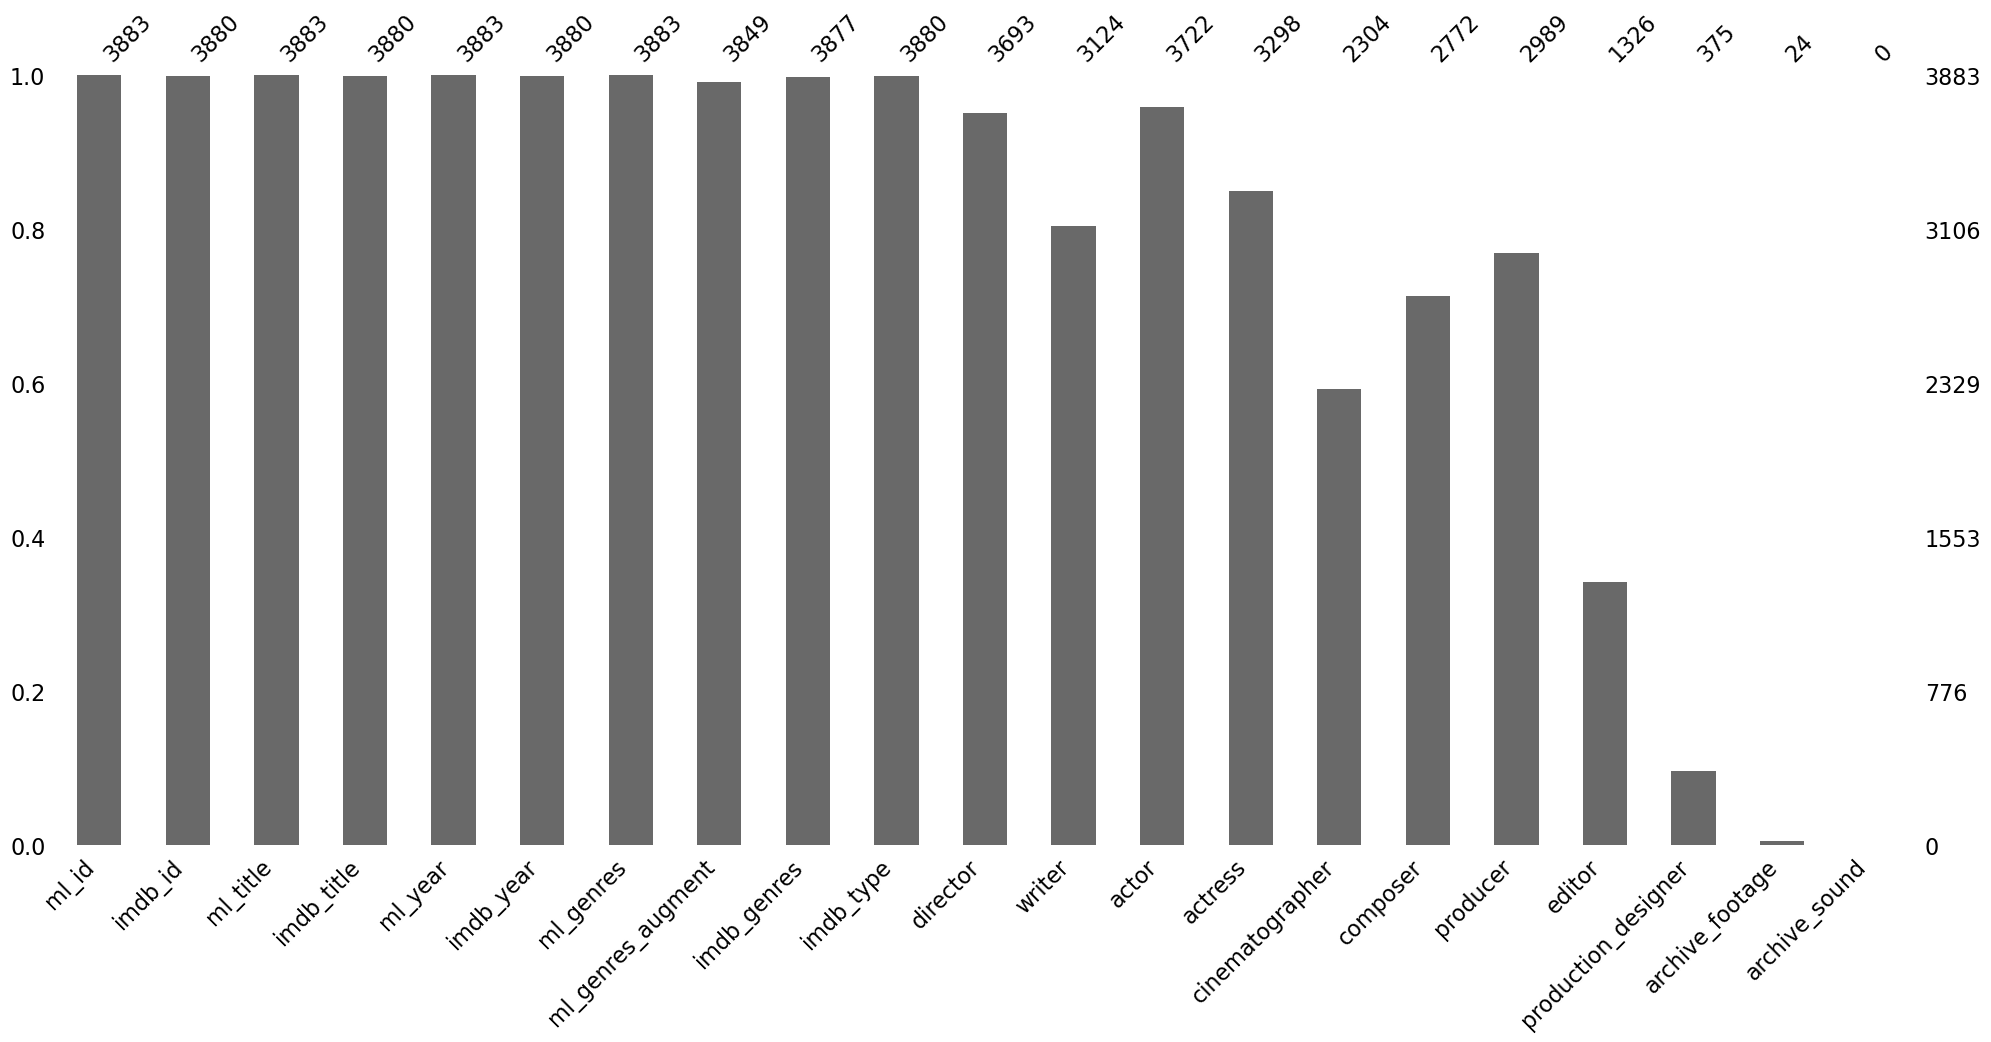

In [312]:
msno.bar(df_ml_1m_imdb)

<Axes: >

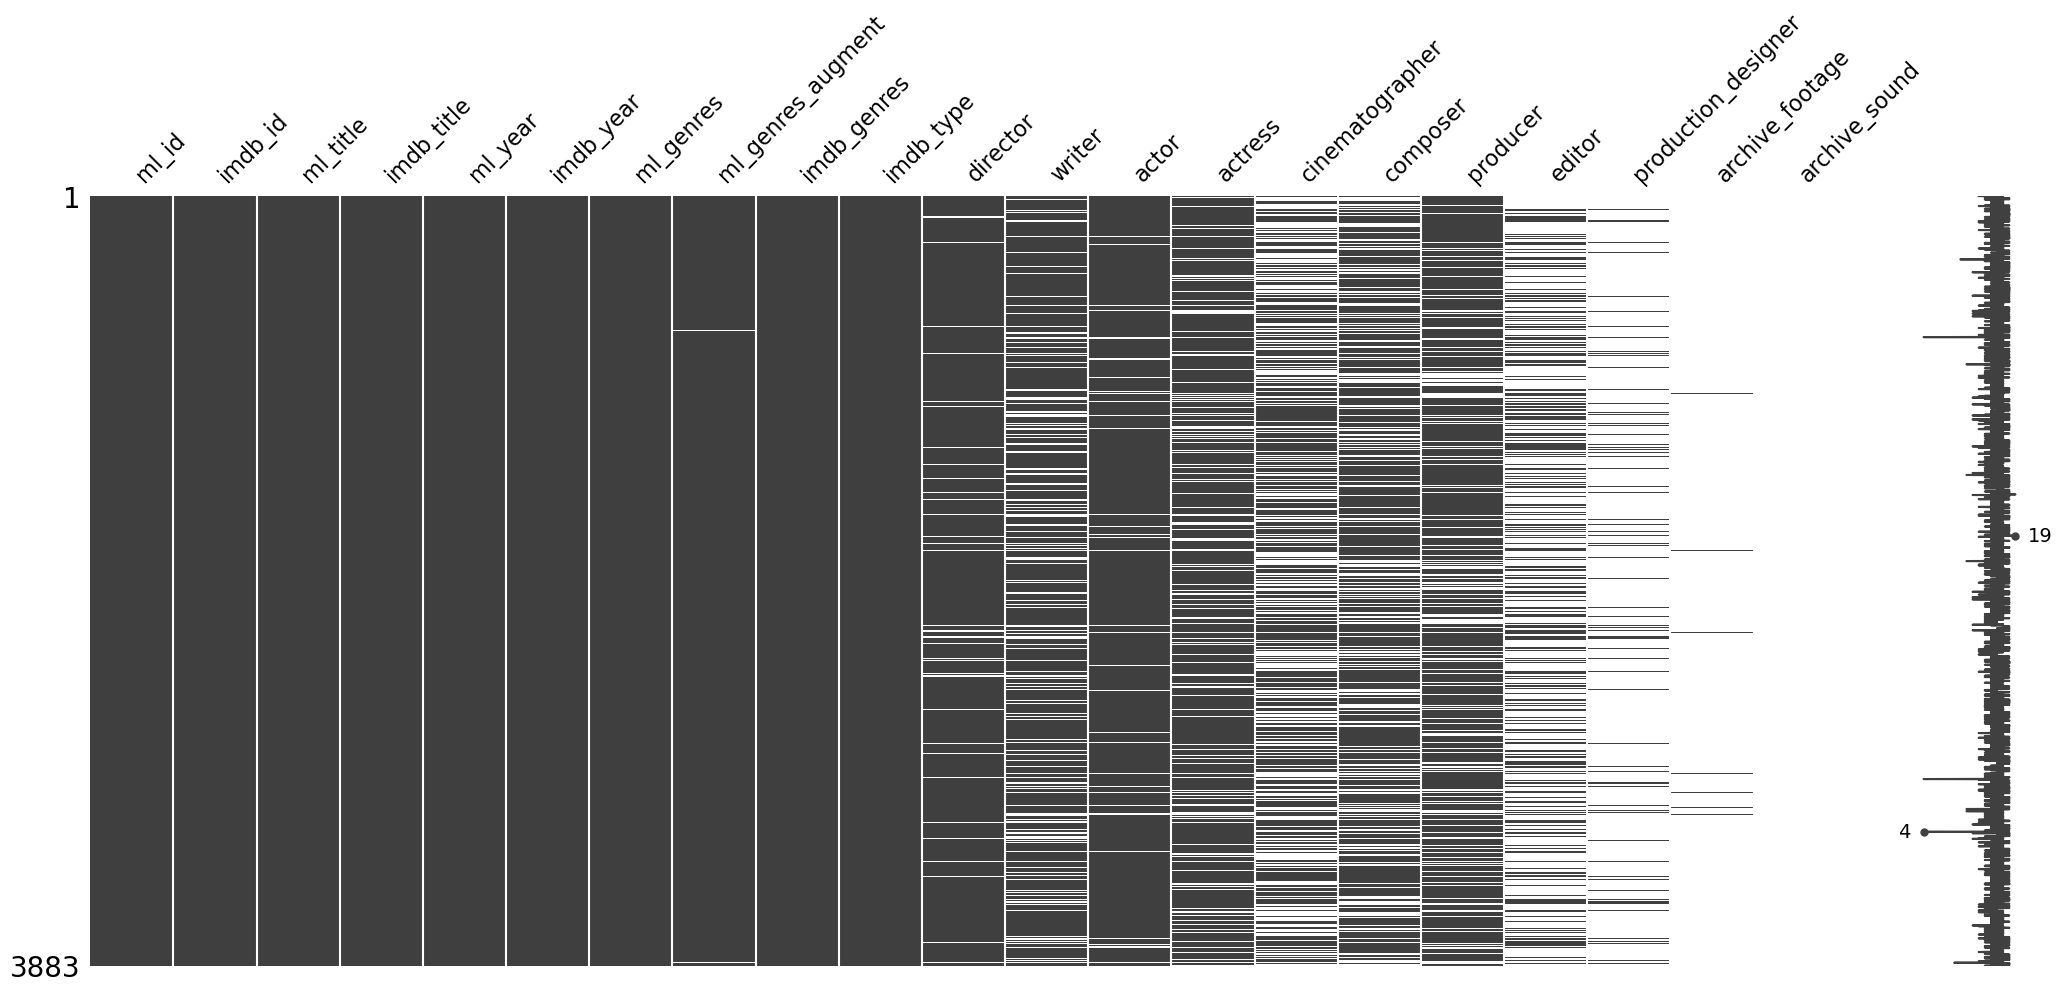

In [8]:
msno.matrix(df)

In [ ]:
crew = ['director', 'writer', 'actor', 'actress', 'cinematographer', 'composer', 'producer', 'editor', 'production_designer', 'archive_footage', 'archive_sound']

columns = ['ml_id', 'imdb_id', 
'ml_title', 'imdb_title', 
'ml_year', 'imdb_year', 
'ml_genres', 'imdb_genres'] + crew

df_ml_1m_imdb = pd.DataFrame(columns=columns)

for i in tqdm(range(len(df_1m_item))): # 1682
    row_dict = {}
    for c in columns:
        row_dict[c] = []

    # ml * 4
    
    # for idx, c in enumerate(['ml_id', 'ml_title', 'ml_year']):
    #     row_dict[c] = df_100k_item[idx][i]
    # row_dict['ml_year'] = int(row_dict['ml_year'].split('-')[-1])
    # row_dict['ml_genres'] = [df_100k_genre['genre'][x-5] for x in range(6, 24)] # drop unknown

    # imdb * 4
    row_dict['imdb_id'] = df_100k_item['imdb_id'][i]
    imdb_id = row_dict['imdb_id']

    if row_dict['imdb_id'] == None:
        # imdb * 3 + 11
        for c in ['imdb_title', 'imdb_year', 'imdb_genres'] + crew:
            row_dict[c] = None
    else:
        idx_25m = df_25m_imdb['tconst'].eq(imdb_id)
        
        if idx_25m.any(): # found in df_25m_imdb
            # imdb * 3
            row_dict['imdb_title'] = df_25m_imdb['primaryTitle'].values[idx_25m][0]
            row_dict['imdb_year'] = int(df_25m_imdb['startYear'].values[idx_25m][0])
            row_dict['imdb_genres'] = df_25m_imdb['genres_imdb'].values[idx_25m][0].split('|')
            # 11
            for c in crew:
                row_dict[c] = df_25m_imdb[c].values[idx_25m][0].split('|')
                if row_dict[c][0] == '\\N':
                    row_dict[c] = None
            

        else: # to find in df_imdb
            idx_imdb = df_imdb['tconst'].eq(imdb_id)
            # imdb * 3

            row_dict['imdb_title'] = df_imdb['primaryTitle'].values[idx_imdb][0]
            row_dict['imdb_year'] = int(df_imdb['startYear'].values[idx_imdb][0])
            row_dict['imdb_genres'] = df_imdb['genres'].values[idx_imdb][0].split(',')

            idx_cast = df_imdb_cast['tconst'].eq(imdb_id)
            df_cast = df_imdb_cast.loc[idx_cast]
            for c in crew:
                idx_sub = df_cast['category'].eq(c)
                if idx_sub.any():
                    df_cast_sub = df_cast.loc[idx_sub]
                    row_dict[c] = df_cast_sub['nconst'].to_list()
                else:
                    row_dict[c] = None

    row = [row_dict[key] for key in columns]
    
    df_ml_100k_imdb.loc[len(df_ml_100k_imdb.index)] = row

In [ ]:
msno.matrix(df_ml_100k_imdb)
msno.matrix(df_ml_100k_imdb)

# df_10m

In [16]:
df_10m = pd.read_table(r"D:\OneDrive - Singapore Management University\datasets\ml-10m\ratings.dat", sep='::')
display(df_10m)
df_10m_movies = pd.read_table(r"D:\OneDrive - Singapore Management University\datasets\ml-10m\movies.dat", sep='::')
display(df_10m_movies)

C:\Users\nieht\AppData\Local\Temp\ipykernel_28836\116235437.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_10m = pd.read_table(r"D:\OneDrive - Singapore Management University\datasets\ml-10m\ratings.dat", sep='::')


,1,122,5,838985046
0,1,185,5.0,838983525
1,1,231,5.0,838983392
2,1,292,5.0,838983421
3,1,316,5.0,838983392
4,1,329,5.0,838983392
...,...,...,...,...
10000048,71567,2107,1.0,912580553
10000049,71567,2126,2.0,912649143
10000050,71567,2294,5.0,912577968
10000051,71567,2338,2.0,912578016


C:\Users\nieht\AppData\Local\Temp\ipykernel_28836\116235437.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_10m_movies = pd.read_table(r"D:\OneDrive - Singapore Management University\datasets\ml-10m\movies.dat", sep='::')


,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
0,2,Jumanji (1995),Adventure|Children|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,4,Waiting to Exhale (1995),Comedy|Drama|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
10675,65088,Bedtime Stories (2008),Adventure|Children|Comedy
10676,65091,Manhattan Melodrama (1934),Crime|Drama|Romance
10677,65126,Choke (2008),Comedy|Drama
10678,65130,Revolutionary Road (2008),Drama|Romance


# df_20m

In [29]:
df_20m = pd.read_csv(r"D:\OneDrive - Singapore Management University\datasets\ml-20m\ratings.csv", delimiter=',')
display(df_20m)
df_20m_movies = pd.read_csv(r"D:\OneDrive - Singapore Management University\datasets\ml-20m\movies.csv", delimiter=',')
display(df_20m_movies)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


# df_25m

In [31]:
df_25m = pd.read_csv(r"D:\OneDrive - Singapore Management University\datasets\ml-25m\ratings.csv", delimiter=',')
display(df_25m)
df_25m_movies = pd.read_csv(r"D:\OneDrive - Singapore Management University\datasets\ml-25m\movies.csv", delimiter=',')
display(df_25m_movies)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


# tests

In [8]:
nf = NetflixData(full=False)
nf.load()
nf.factor_info

[(array([   0,    1,    2, ..., 9977, 9978, 9979]),
  array([1478381, 1045221,  811218, ..., 1006729,  609169, 2577021]),
  array(['1478381', '1045221', '811218', ..., '1006729', '609169',
         '2577021'], dtype='<U21')),
 (array([   0,    1,    2, ..., 3359, 3360, 3361]),
  array([    3,     9,    17, ..., 17753, 17762, 17765]),
  array(['Character', "Class of Nuke 'Em High 2", '7 Seconds', ...,
         'Maslin Beach', 'Gattaca', "Godzilla's Revenge"], dtype='<U70'))]

In [9]:
nfgc = NetflixGenreCastData(full=False, source='imdb')
nfgc.load()

[(array([   0,    1,    2, ..., 9989, 9990, 9991]),
  array([2567280, 1478381, 1045221, ..., 2577021, 1541139,  609169]),
  array(['2567280', '1478381', '1045221', ..., '2577021', '1541139',
         '609169'], dtype='<U21')),
 (array([   0,    1,    2, ..., 4942, 4943, 4944]),
  array([    2,     3,     9, ..., 17762, 17765, 17767]),
  array(['Isle of Man TT 2004 Review', 'Character',
         "Class of Nuke 'Em High 2", ..., 'Gattaca', "Godzilla's Revenge",
         'Fidel Castro: American Experience'], dtype='<U98')),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
         'Game-Show', 'History', 'Horror', 'Music', 'Mus

## test ml

In [99]:
data = MovieLensData(size='100k')
data.load(overwrite_cache=True)
data.X

<943x1682 sparse matrix of type '<class 'numpy.intc'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [100]:
data = MovieLensData(size='1m')
data.load(overwrite_cache=True)
data.X

<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
	with 1000209 stored elements in Compressed Sparse Row format>

In [101]:
data.__dict__

{'X': <6040x3706 sparse matrix of type '<class 'numpy.intc'>'
 	with 1000209 stored elements in Compressed Sparse Row format>,
 'Xs': None,
 'factors': None,
 'factor_info': [(array([   0,    1,    2, ..., 6037, 6038, 6039]),
   array([   1,    2,    3, ..., 6038, 6039, 6040]),
   array(['1', '2', '3', ..., '6038', '6039', '6040'], dtype='<U11')),
  (array([   0,    1,    2, ..., 3703, 3704, 3705]),
   array([   1,    2,    3, ..., 3950, 3951, 3952]),
   array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
          ..., 'Tigerland (2000)', 'Two Family House (2000)',
          'Contender, The (2000)'], dtype='<U82'))],
 'is_single': True,
 'name': 'ml_1m',
 'root': 'D:\\OneDrive - Singapore Management University\\datasets',
 'cache_path': 'D:\\OneDrive - Singapore Management University\\cache',
 'pickle_path': 'D:\\OneDrive - Singapore Management University\\cache\\ml_1m.pickle',
 'size': '1m',
 'df_ratings':           uid   iid  rating           timestamp  row_idx  

In [102]:
ml_100k_user = MovieLensUserData(size='100k')
ml_100k_user.load(overwrite_cache=True)
ml_100k_user.Xs

[<943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>]

In [96]:
ml_1m_user = MovieLensUserData(size='1m')
ml_1m_user.load(overwrite_cache=True)
ml_1m_user.Xs

[<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
 	with 1000209 stored elements in Compressed Sparse Row format>,
 <6040x82 sparse matrix of type '<class 'numpy.float64'>'
 	with 22451 stored elements in Compressed Sparse Row format>]

In [103]:
from datasets import MovieLensGenreCastData
data = MovieLensGenreCastData(size='100k')
data.load(overwrite_cache=True)
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [104]:
from datasets import MovieLensGenreCastData
data = MovieLensGenreCastData(size='1m')
data.load(overwrite_cache=True)
data.Xs

[<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
 	with 1000209 stored elements in Compressed Sparse Row format>,
 <41x3706 sparse matrix of type '<class 'numpy.float64'>'
 	with 8946 stored elements in Compressed Sparse Row format>,
 <9488x3706 sparse matrix of type '<class 'numpy.float64'>'
 	with 18382 stored elements in Compressed Sparse Row format>]

In [111]:
from datasets import MovieLensGenreCastUserData
data = MovieLensGenreCastUserData(size='100k')
data.load(overwrite_cache=True)
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [112]:
data.factors

[[0, 1], [0, 2], [3, 1], [4, 1]]

In [114]:
len(data.factor_info)

5

In [116]:
data.X

<5677x1763 sparse matrix of type '<class 'numpy.float64'>'
	with 115836 stored elements in List of Lists format>

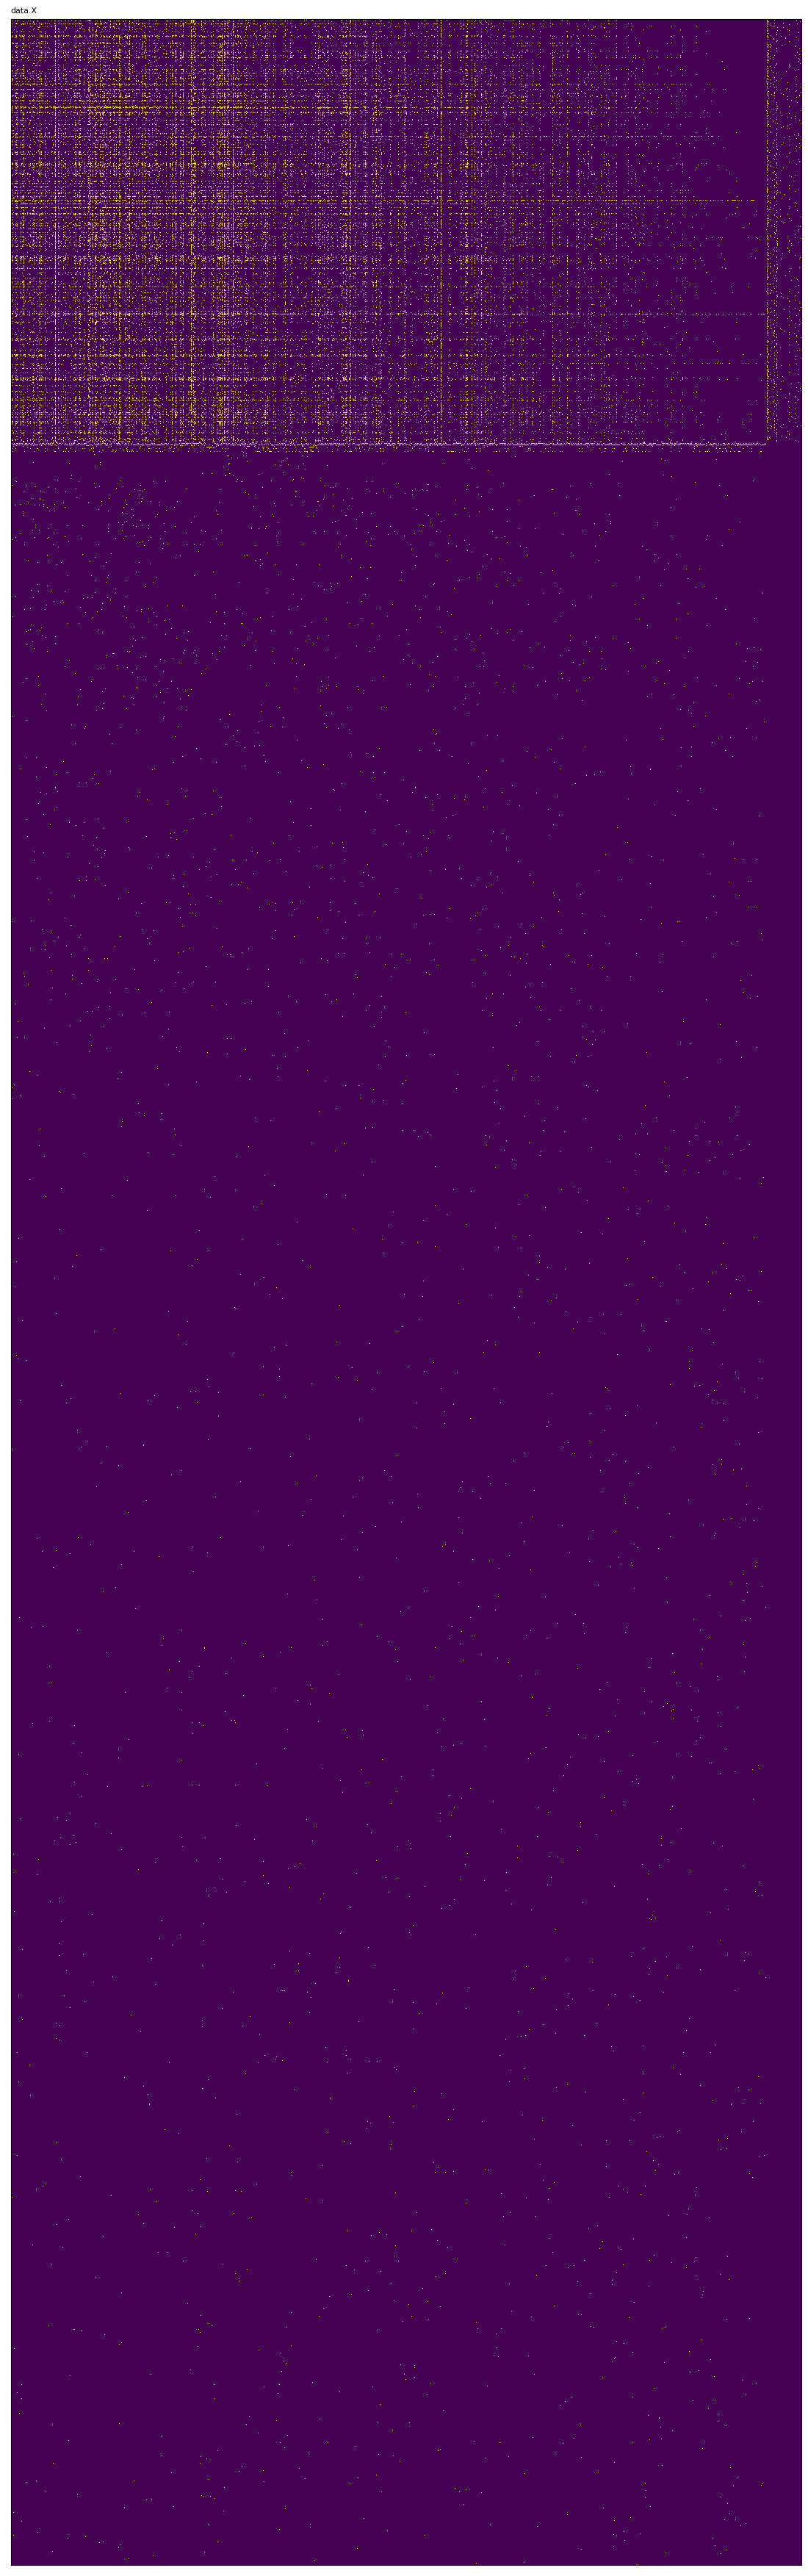

In [119]:
from utils import show_matrix

show_matrix(settings=[(data.X.toarray(), [0, 0], 'data.X')], scaling=3)